# BI-PRS - Semestral work 3

In [1]:
# supress warnings for presentation purposes
# all important warnings will be pointed out
options(warn = -1) # disable warnings
# options(warn = 0) # enable warnings

In [2]:
# Dataset selection according to the represant's data
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Kamil Dedecius')
cat('\nYear =', 2011 + M)

Parameter M = 2 => Kamil Dedecius
Year = 2013

In [3]:
# Neccessary imports

# Ignore package startup messages for presentation purposes
suppressPackageStartupMessages({
    library(eurostat)
    library(car)
    library(tseries)
    library(lmtest)
    library(countrycode)
    library(stringr)
    library(ggplot2)
    library(psych)
    library(corrplot)
    library(GGally)
    library(olsrr)
    library(trend)
    library(gridExtra)
    library(cowplot)
})

## Abstract

The project examines the [**Gross Domestic Product (GDP)**](https://www.investopedia.com/terms/g/gdp.asp) of **European countries** in **2013**. The study investigates [**nominal GDP per capita**](https://www.investopedia.com/terms/n/nominalgdp.asp) in particular.

**Table of contents:**
- Dataset preparation
- GDP elucidation
- Regressors selection
- Dependencies visualization
- Statistical tests
- Linear model
- Outliers
- Multicollinearity
- Model Assumptions Tests
- Final Model

## Data preparation

In [72]:
# Load the dataset
suppressMessages({ # suppress information about dataset storage
        data <- get_eurostat(id='nama_10_pc')
    })
head(data, 5)

freq,unit,na_item,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,CLV10_EUR_HAB,B1GQ,AL,1995-01-01,1310
A,CLV10_EUR_HAB,B1GQ,AL,1996-01-01,1410
A,CLV10_EUR_HAB,B1GQ,AL,1997-01-01,1270
A,CLV10_EUR_HAB,B1GQ,AL,1998-01-01,1390
A,CLV10_EUR_HAB,B1GQ,AL,1999-01-01,1580


Transform the dataset, leaving only **Gross Domestic Product per capita** in euros in **2013** for individual European countries.

In [5]:
colnames(data)[4] <- 'country'  # rename "geo" column
colnames(data)[6] <- 'GDPpc'    # rename "values" column
data <- subset(data,
               na_item == 'B1GQ' &     # Gross domestic product at market prices
               unit == 'CP_EUR_HAB' &  # Current prices, euro per capita
               TIME_PERIOD == '2013-01-01' &
               !(country %in% c(
                   'EU27_2020',  # European Union - 27 countries (from 2020)
                   'EU28',       # European Union - 28 countries (2013-2020)
                   'EU15',       # European Union - 15 countries (1995-2004)
                   'EA',         # Euro area
                   'EA20',       # Euro area – 20 countries (from 2023)
                   'EA19',       # Euro area - 19 countries  (2015-2022)
                   'EA12'        # Euro area - 12 countries (2001-2006)
               )),
               c(country, GDPpc))
data$country <- countrycode(data$country, 'eurostat', 'country.name')
data$country <- factor(data$country)
head(data, 3)

country,GDPpc
<fct>,<dbl>
Albania,3320
Austria,38210
Belgium,35210


In [6]:
any(is.na(data$GDPpc)) # Check for NA values

[1] FALSE

## GDP elucidation

Analyze the `GDPpc` using statistical metrics and visualizations.

In [7]:
describe(data$GDPpc, ranges=F, quant=c(0.25, 0.5, 0.75), IQR=T)[, -1]

,n,mean,sd,skew,kurtosis,se,IQR,Q0.25,Q0.5,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,37,28576.49,26468.96,1.873744,3.839155,4351.471,27700,10480,18680,38180


Skewness and the strong deviation of the mean from the median indicate the presence of an *“eastern”* tail in the distribution. Let's check it out on the histogram.

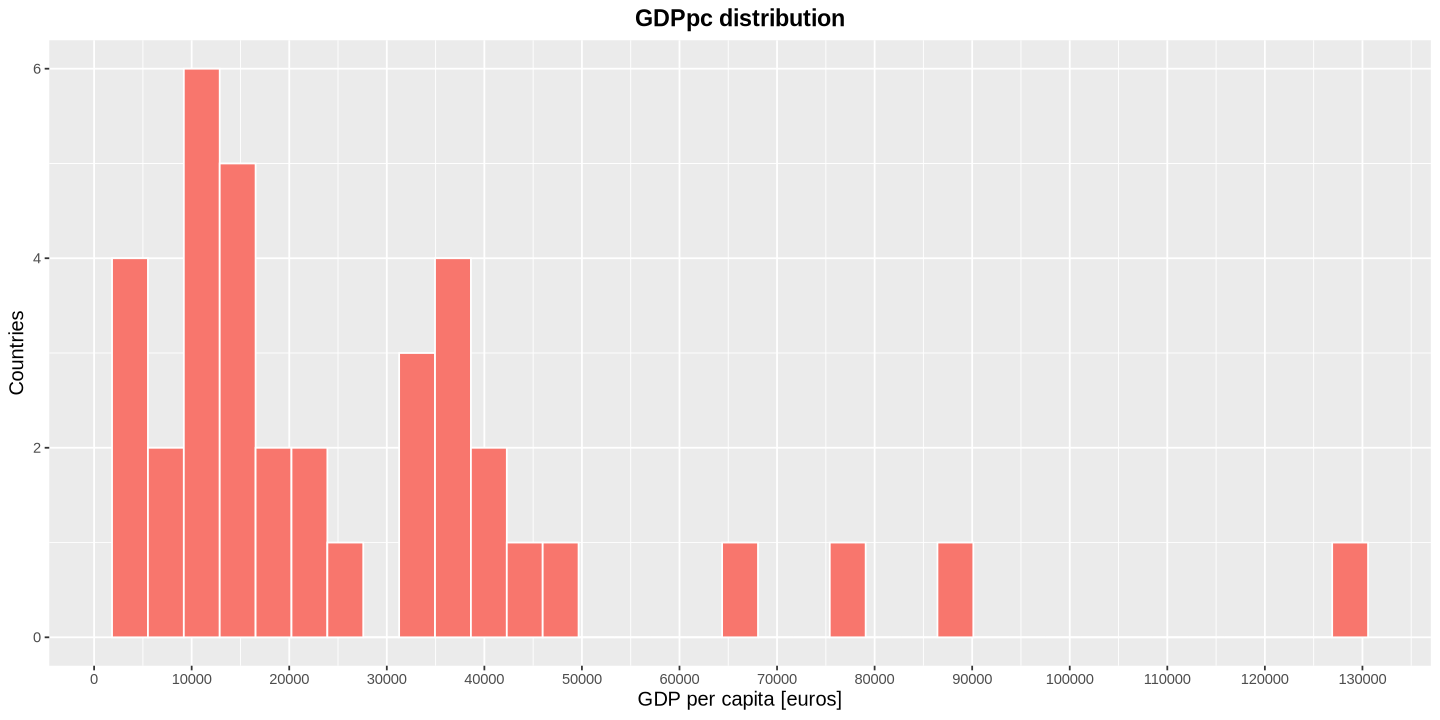

In [8]:
options(repr.plot.width=12, repr.plot.height=6)                        # figure settings 

ggplot(data, aes(x=GDPpc)) +                                           
  geom_histogram(bins=35, fill='#f8766d', col='white') +               # hist
  labs(title='GDPpc distribution',                                     # labels        
       x='GDP per capita [euros]',
       y='Countries') + 
  scale_x_continuous(breaks=scales::pretty_breaks(n=12)) +             # set x axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

As expected, the distribution has a tail. Several countries have a much higher `GDPpc` than the rest.

In addition, three potential clusters can be noticed in the graph: 

1. $\mathrm{GDPpc} \le 30000$,
2. $30000 < \mathrm{GDPpc} \le 60000$,
3. $60000 < \mathrm{GDPpc}$.

Each of these clusters may be amenable to its own distribution.

## Regressors selection

[Many factors](https://www.investopedia.com/articles/investing/051415/how-calculate-gdp-country.asp) can affect the GDP per capita and a country's economy. Below we offer three variants of a continuous variable and one binary. [Human Development Report](https://en.wikipedia.org/wiki/Human_Development_Report) will be a data source for regressors. [(link)](https://hdr.undp.org/data-center/documentation-and-downloads)

### Continuous regressors

In [9]:
# Load the dataset
extra_src_url <- 'https://hdr.undp.org/sites/default/files/2023-24_HDR/HDR23-24_Composite_indices_complete_time_series.csv'

In [10]:
extra_data <- read.csv(url(extra_src_url), encoding='UTF-8')
extra_data$country <- str_replace(extra_data$country, 'T\xfcrkiye', 'Turkey')
head(extra_data, 5)

,iso3,country,hdicode,region,hdi_rank_2022,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,⋯,pop_total_2013,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,Afghanistan,Low,SA,182,0.284,0.292,0.299,0.307,0.300,⋯,31.5412085,32.7162100,33.7534990,34.6362075,35.6434175,36.6867840,37.769498,38.972231,40.099462,41.128771
2,ALB,Albania,High,ECA,74,0.649,0.632,0.616,0.618,0.623,⋯,2.8870140,2.8841020,2.8824805,2.8810630,2.8793550,2.8770130,2.873883,2.866849,2.854710,2.842321
3,DZA,Algeria,High,AS,93,0.593,0.596,0.601,0.602,0.603,⋯,38.0006265,38.7601675,39.5431545,40.3393285,41.1365460,41.9270070,42.705368,43.451666,44.177968,44.903225
4,AND,Andorra,Very High,,35,NA,NA,NA,NA,NA,⋯,0.0713665,0.0716215,0.0717455,0.0725405,0.0738365,0.0750135,0.076343,0.077700,0.079034,0.079824
5,AGO,Angola,Medium,SSA,150,NA,NA,NA,NA,NA,⋯,26.1470020,27.1283365,28.1277210,29.1547455,30.2086280,31.2735330,32.353588,33.428486,34.503774,35.588987


In [11]:
# Check if the additional dataset has all countries required
all(data$country %in% extra_data$country)

[1] TRUE

Only some features are needed, which are:
- `LE`: Life Expectancy at Birth (years)
- `MYS`: Mean Years of Schooling (years)
- `EYS`: Expected Years of Schooling (years)
- `GNIpc`: Gross National Income Per Capita (2017 PPP$)

*all for 2013

In [12]:
extra_data <- subset(extra_data,
       country %in% data$country,
       c(
           'country',
           'le_2013',  # Life Expectancy at Birth [years] ~ LE
           'mys_2013',  # Mean Years of Schooling [years] ~ MYS
           'eys_2013',  # Expected Years of Schooling [years] ~ EYS
           'gnipc_2013'  # Gross National Income Per Capita [2017 PPP$] ~ GNIpc
       ))

In [13]:
any(is.na(extra_data)) # Check for NA values

[1] FALSE

In [14]:
data <- merge(data, extra_data, by='country') # Merge the datasets

The indicators in one way or another related to the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) were taken as a basis.

First of all, let's look at how HDI is calculated:

1. **Life Expectancy Index**: $\mathrm{LEI} = \frac{\mathrm{LE} - 20}{65}$
2. **Education Index**: $\mathrm{EI} = \frac{\frac{\mathrm{MYS}}{15} + \frac{\mathrm{EYS}}{18}}{2}$
3. **Income Index**: $\mathrm{II} = \frac{\ln(\mathrm{GNIpc}) - \ln(100)}{\ln(750)}$
4. **Human Development Index**: $\mathrm{HDI} = \sqrt[3]{\mathrm{LEI} \cdot \mathrm{EI} \cdot \mathrm{II}}$

Instead of using HDI itself, we take its components. However, just taking the presented indexes is not a good idea. Let's see why.

The problem with using LEI is that its values are much more difficult to interpret than LE values. As a consequence, we leave LE untouched.

GNIpc is calculated using the following formula$$\mathrm{GNIpc} = \mathrm{GDPpc} + \mathrm{NFIApc},$$where NFIApc is **Net Factor Income from Abroad per capita** and is calculated as$$\mathrm{NFIApc} = \frac{\text{Money flowing from foreign countries} - \text{Money flowing to foreign countries}}{\text{Population}}.$$

Since GNIpc already contains GDPpc, using it would mean that our model would implicitly learn to predict NFIApc. This is not quite the right approach to the problem at hand. Therefore, we only take NFIApc as a regressor. However, we cannot simply subtract euro GDPpc from dollar GNIpc, we need to convert GNIpc into euros beforehand. For this purpose we use [this](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2013.html#:~:text=Average%20exchange%20rate%20in%202013%3A%201.3284%20USD.) exchange rate.

In [15]:
data$LE <- data$le_2013
data$EI <- (data$mys_2013 / 15 + data$eys_2013 / 18) / 2
data$NFIApc <- data$gnipc_2013 / 1.3284 - data$GDPpc
data <- data[, c('country', 'GDPpc', 'LE', 'EI', 'NFIApc')]
head(data, 5)

,country,GDPpc,LE,EI,NFIApc
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,Albania,3320,78.123,0.7781896,5376.903
2,Austria,38210,81.078,0.8383914,1791.626
3,Belgium,35210,80.468,0.9221770,1962.076
4,Bulgaria,5790,74.849,0.7824033,8144.946
5,Croatia,10480,77.843,0.8044435,7332.921


#### Binary factor

The factor of the country's entry into the [Blue Banana](https://en.wikipedia.org/wiki/Blue_Banana) area was chosen as a binary predictor. The intuition behind this decision is based on the fact that the cities within this zone are of great economic importance.

Here's a [**link**](https://en.wikipedia.org/wiki/Blue_Banana) to the data source.

In [16]:
data$BB_entry <- (data$country %in% c(
    'Austria',
    'Belgium',
    'France',
    'Germany',
    'Italy',
    'Luxembourg',
    'Netherlands',
    'United Kingdom',
    'Liechtenstein',
    'Switzerland'
))

head(data, 5)

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Albania,3320,78.123,0.7781896,5376.903,FALSE
2,Austria,38210,81.078,0.8383914,1791.626,TRUE
3,Belgium,35210,80.468,0.9221770,1962.076,TRUE
4,Bulgaria,5790,74.849,0.7824033,8144.946,FALSE
5,Croatia,10480,77.843,0.8044435,7332.921,FALSE


## Data Visualization

In [17]:
# prepare common parameters and styles
text <- geom_text(aes(label=country), size=3, vjust=-1, hjust=0.5)
scale <- scale_y_continuous(breaks=scales::pretty_breaks(n=5))
theme <- theme(
        plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
        axis.title = element_text(size=12),                                # axis title size
    )

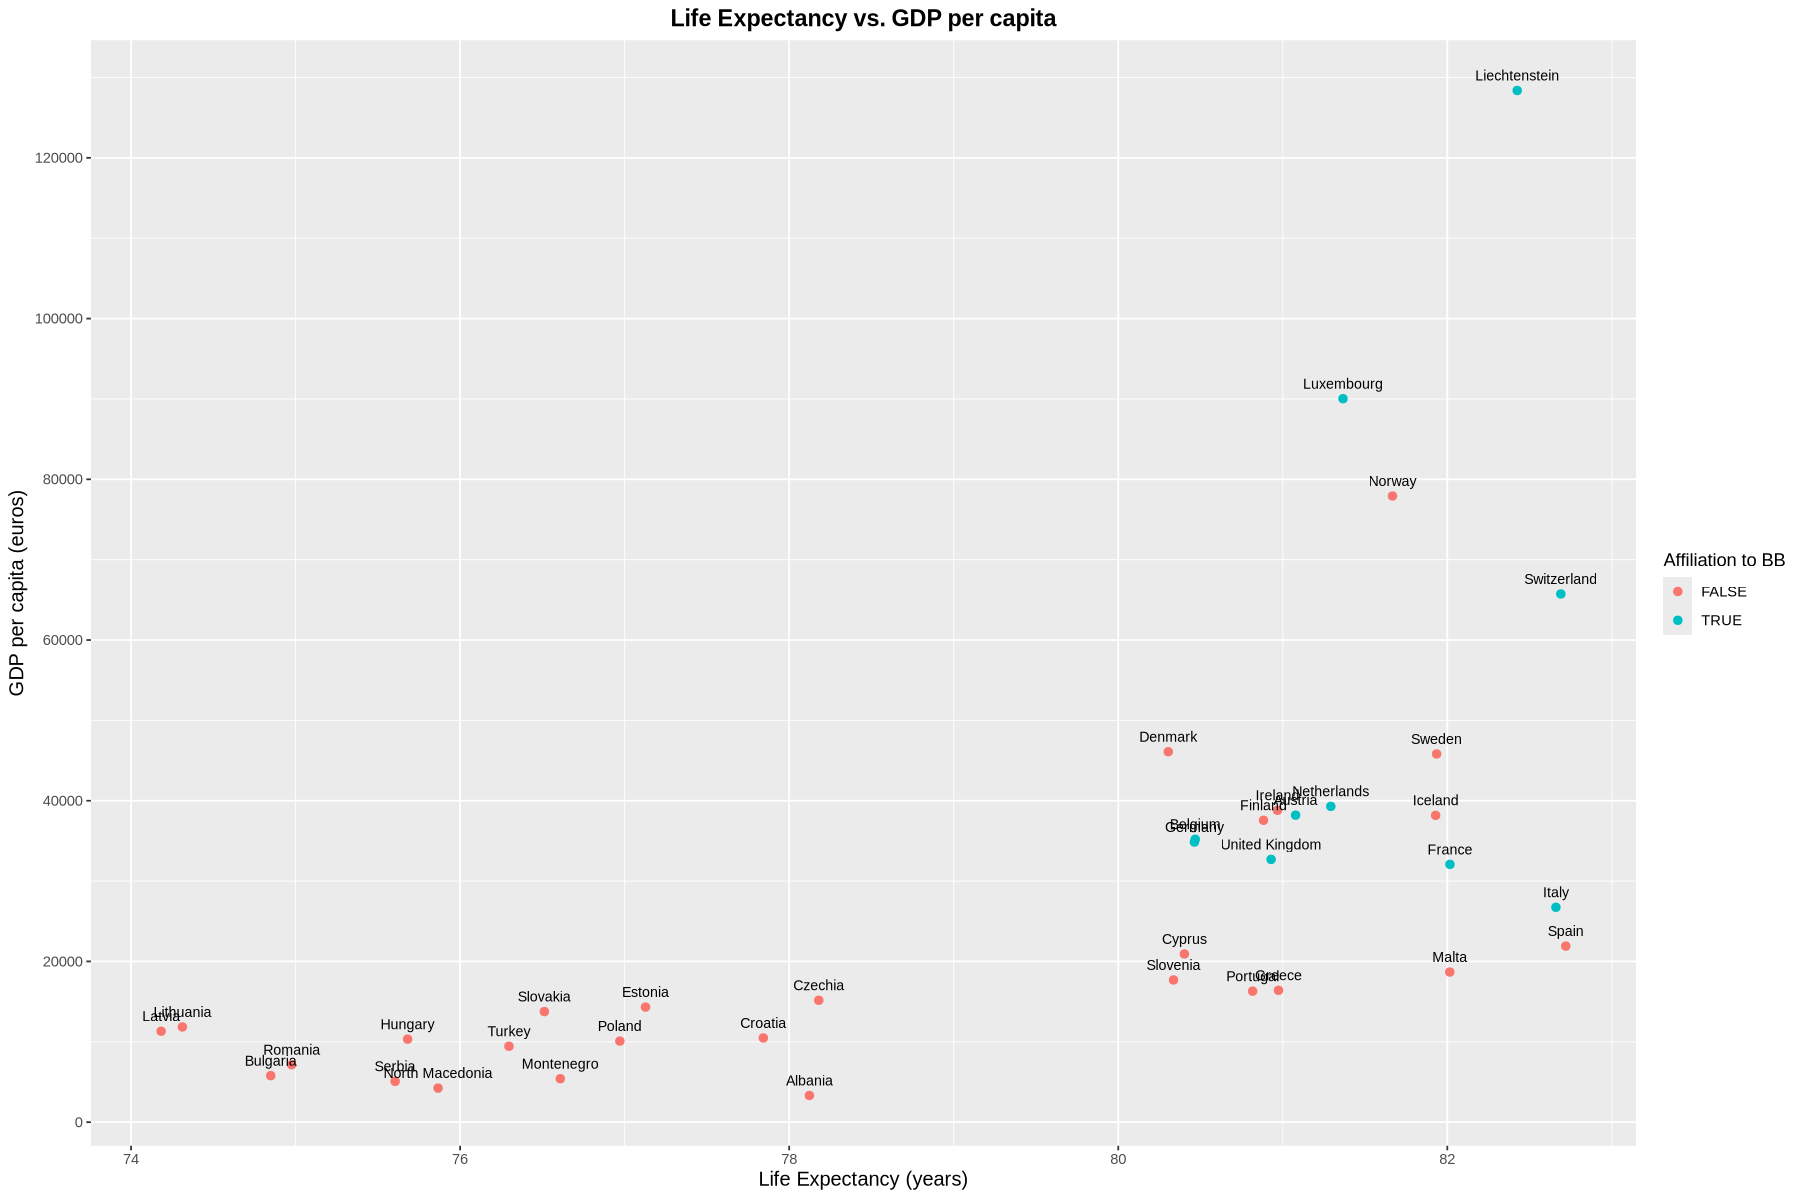

In [18]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

# save labs for later use for the same scatter plot in different contexts
labs_le <- labs(title='Life Expectancy vs. GDP per capita',                     # labels
               x='Life Expectancy (years)',
               y='GDP per capita (euros)',
               color='Affiliation to BB')
    
ggplot(data, aes(x=LE, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +                                    
  labs_le + text + scale + theme

- The plot helps visualize economic disparities and their potential impact on life expectancy across different countries.
- There is a visible trend where countries with higher GDP per capita and affiliation to BB generally have higher life expectancies.
- The chart also shows three clusters, which were mentioned earlier.

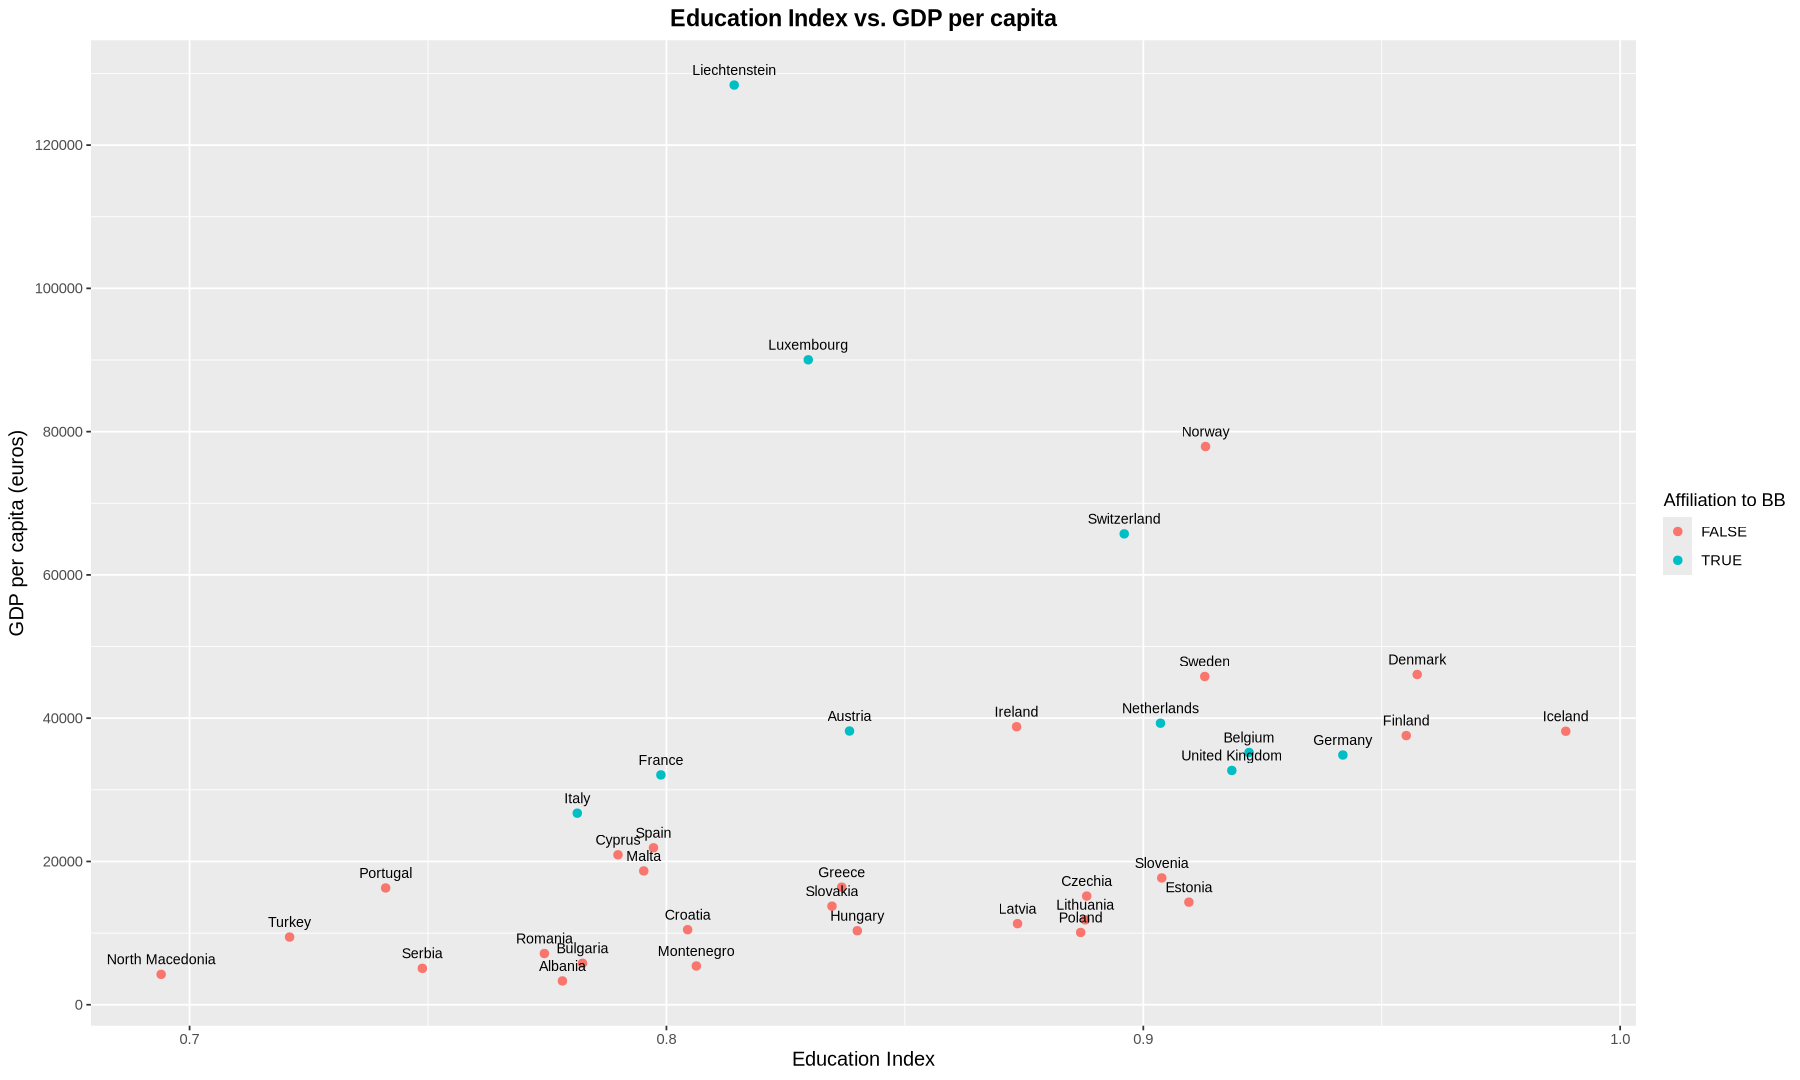

In [19]:
options(repr.plot.width=15, repr.plot.height=9)                        # figure settings 

labs_ei <- labs(title='Education Index vs. GDP per capita',                     # labels
               x='Education Index',
               y='GDP per capita (euros)',
               color='Affiliation to BB')

ggplot(data, aes(x=EI, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) + 
  labs_ei + text + scale + theme

- There is a general trend showing that countries with higher Education Index scores tend to have higher GDP per capita.
- Outliers like Liechtenstein and Luxembourg have exceptionally high GDP per capita compared to their Education Index.
- Countries with lower Education Index scores (around $0.7$ to $0.8$) generally have lower GDP per capita, such as North Macedonia, Turkey, and Serbia.

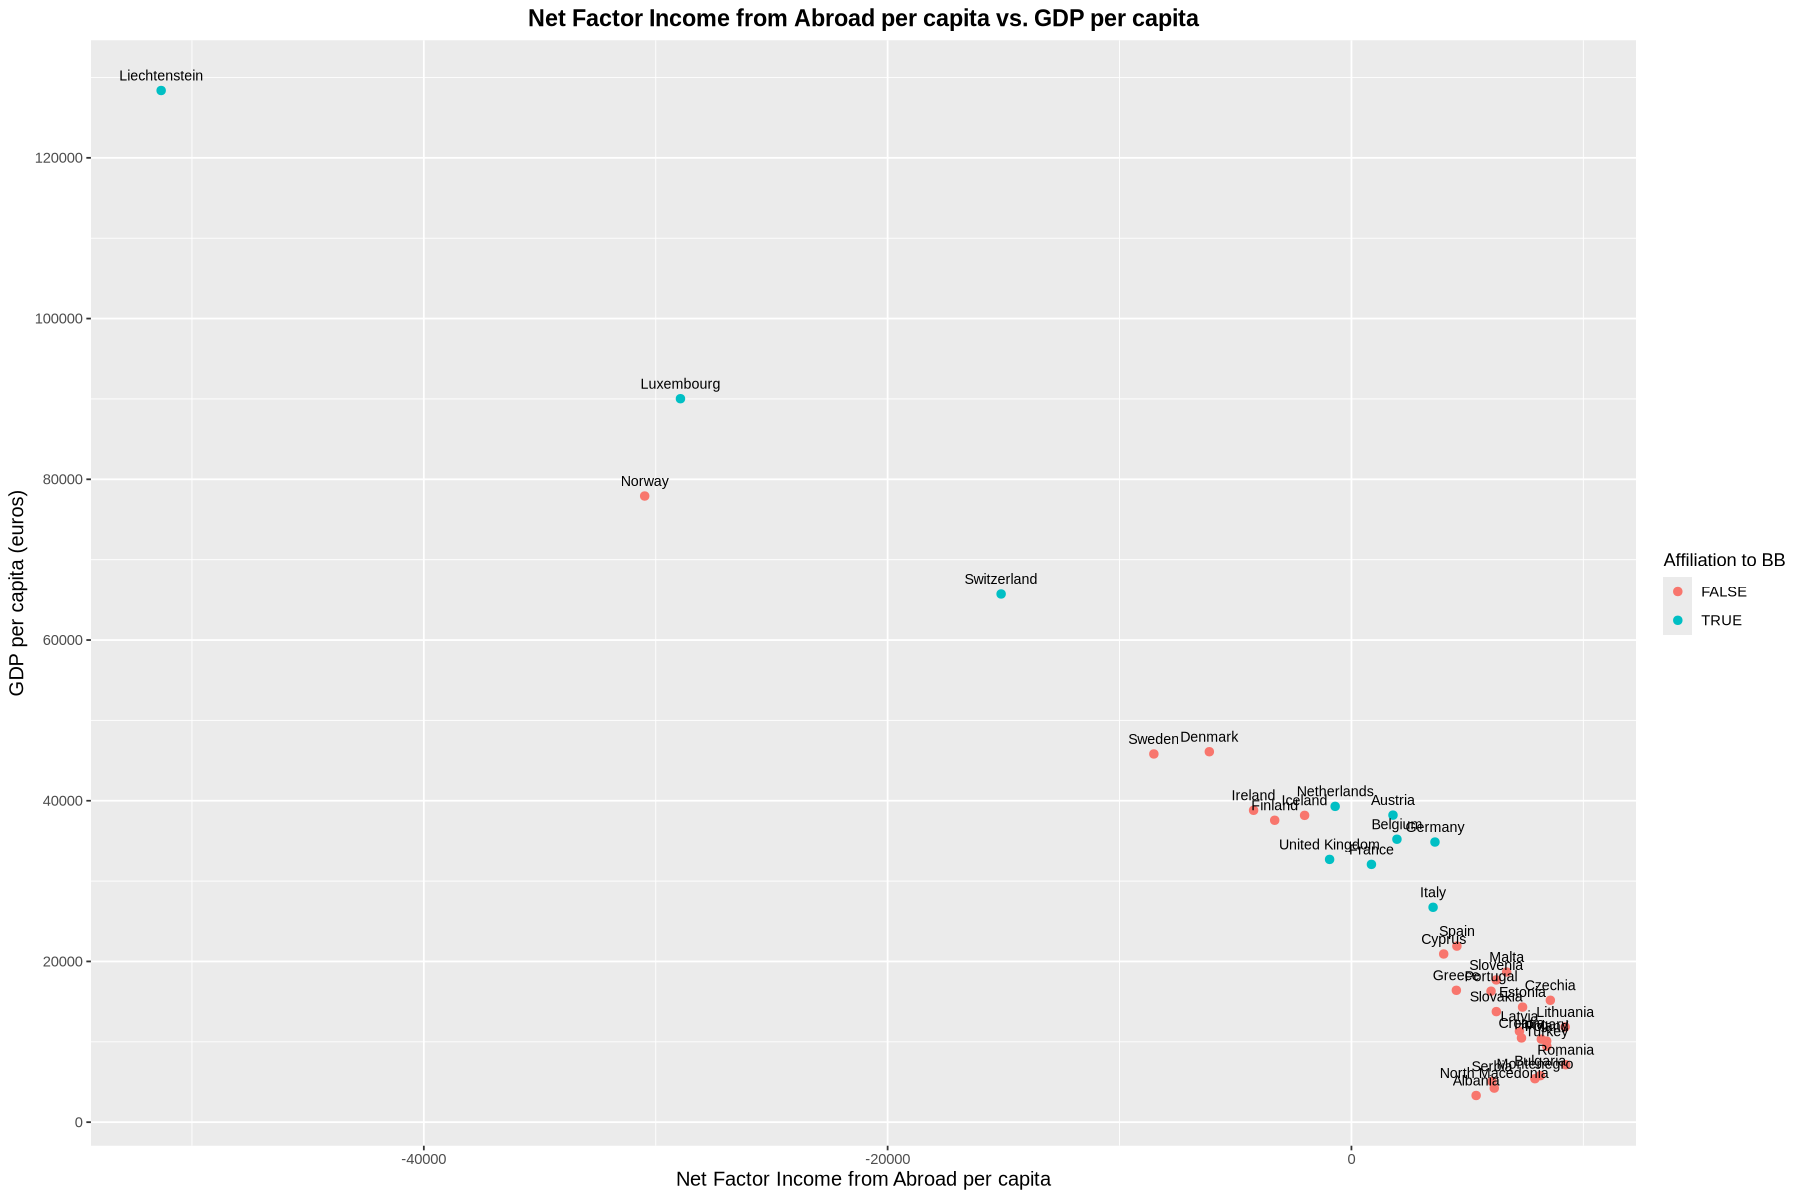

In [20]:
options(repr.plot.width=15, repr.plot.height=10) # figure settings 
labs_nfiapc <- labs(title='Net Factor Income from Abroad per capita vs. GDP per capita',   # labels
                   x='Net Factor Income from Abroad per capita',
                   y='GDP per capita (euros)',
                   color='Affiliation to BB')

ggplot(data, aes(x=NFIApc, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  labs_nfiapc + text + scale + theme

- Liechtenstein, Luxembourg, and Norway are notable outliers with high GDP per capita despite negative or zero Net Factor Income from Abroad per capita.
- Most countries cluster around lower GDP per capita values and with low positive Net Factor Income from Abroad per capita.
- The majority of countries have positive Net Factor Income from Abroad per capita, but there are a lot of countries with negative values, suggesting that they spend more abroad than they receive.

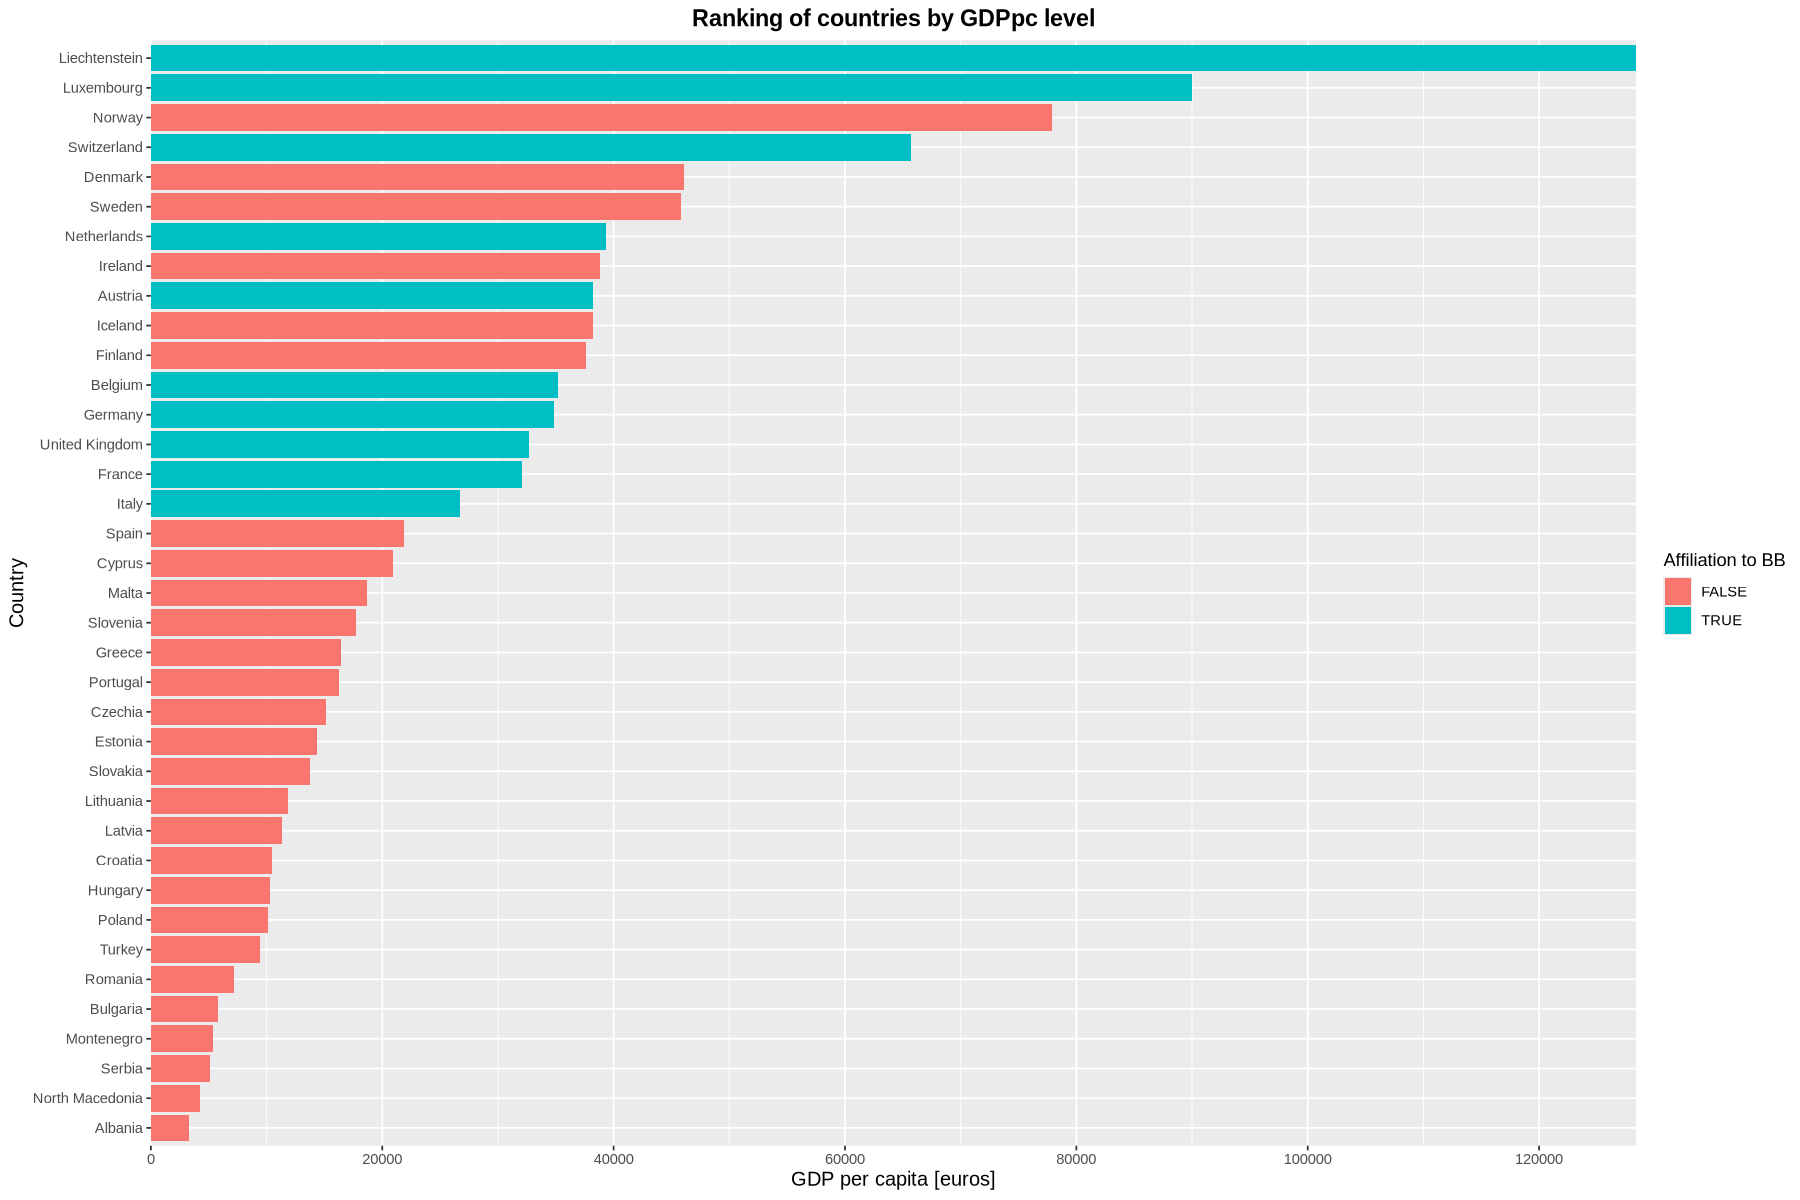

In [21]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

ggplot(data, aes(x=GDPpc, y=reorder(country, GDPpc), fill=BB_entry)) +
  geom_bar(stat='identity') +
  labs(title='Ranking of countries by GDPpc level',
       x='GDP per capita [euros]',
       y='Country',
       fill='Affiliation to BB') +
  scale_x_continuous(breaks=scales::pretty_breaks(n=6), expand=c(0, 0)) + theme

- Top Performers: Liechtenstein, Luxembourg and Norway are at the top of the list, having the highest GDP per capita.
- Mid-range Performers: Countries like Germany, the United Kingdom, and France are in the middle range, with moderate GDP per capita levels.
- Lower Performers: Countries like Albania, North Macedonia, and Serbia are at the bottom, with the lowest GDP per capita.
- Countries that are listed in BB are placed only in best performing half of the countries presented.

## Dependencies of the regressors

Before examining the dependencies between regressors, we need to choose tests that can be applied to all $6$ pairs. For this purpose, it is necessary to check if the data satisfy the assumptions of the tests.

### Monotonic relationship

Let's take a look at a visualization of all possible pairs.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


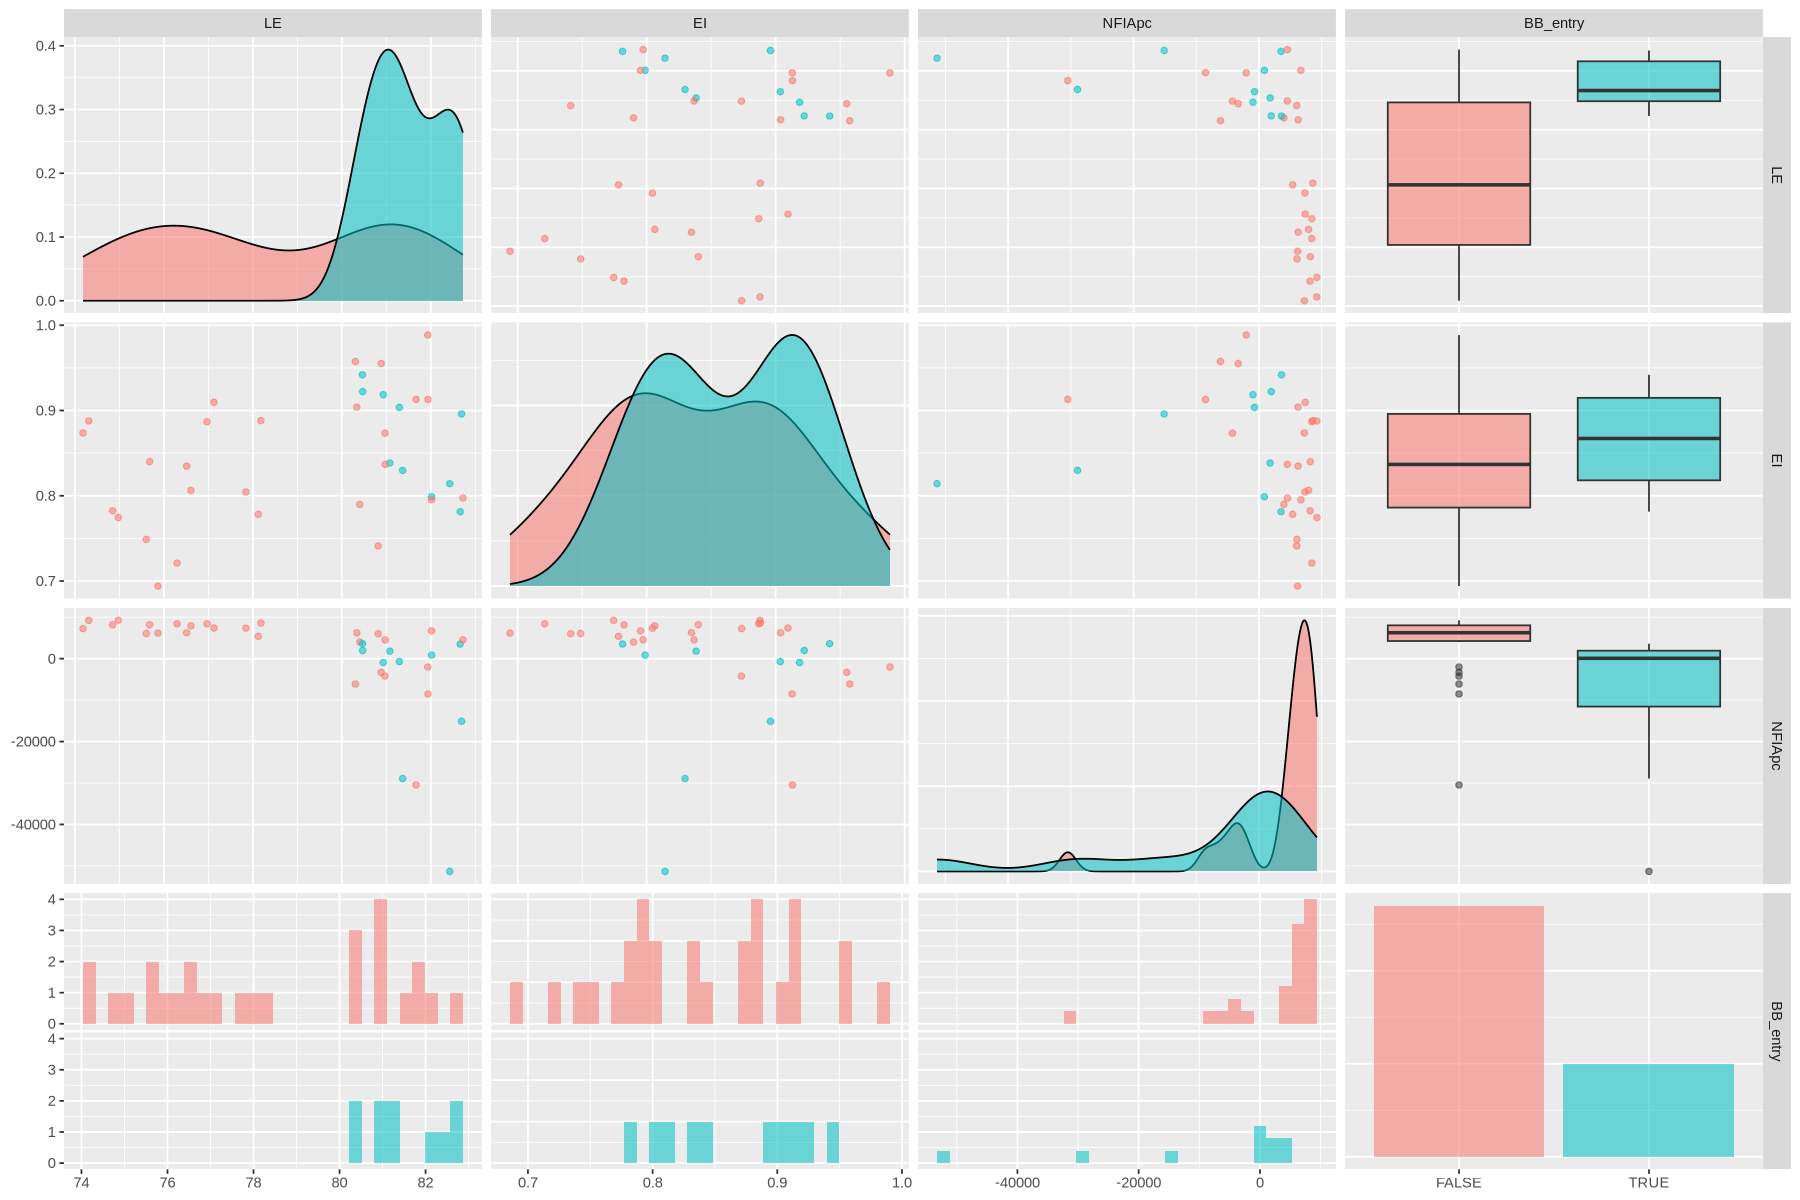

In [22]:
ggpairs(data[, -c(1, 2)], ggplot2::aes(col=BB_entry, alpha=0.2), upper=list(continuous='points'))

All but one pair satisfies the monotonicity assumption. Let us consider this exception in detail.

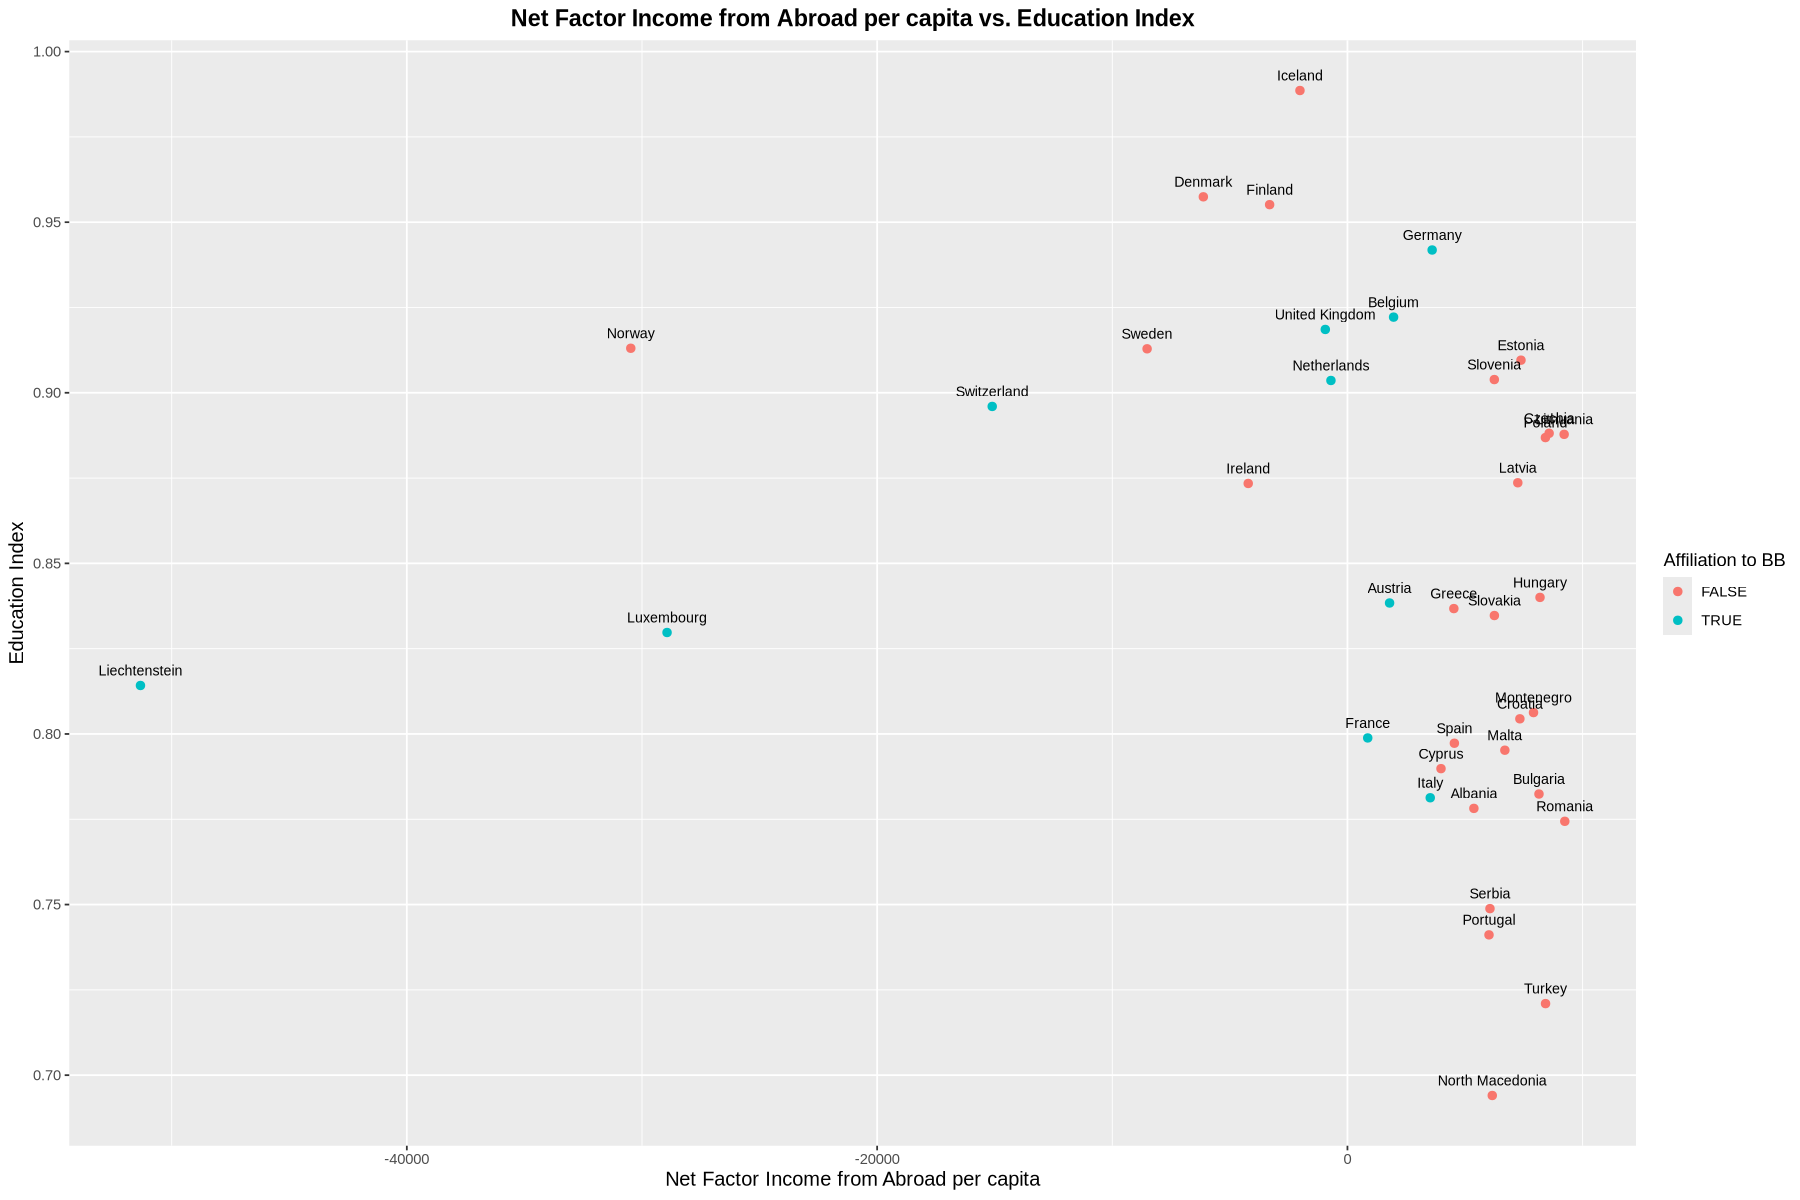

In [23]:
ggplot(data, aes(x=NFIApc, y=EI)) +
  geom_point(aes(col=BB_entry), size=2) +
  labs(title='Net Factor Income from Abroad per capita vs. Education Index',   # labels
       x='Net Factor Income from Abroad per capita',
       y='Education Index',
       color='Affiliation to BB') +
  text + scale + theme
  

Liechtenstein, Luxembourg and Norway stand out too much from the overall distribution. They will be removed during the test so that a suitable test can be applied. See below.

Visually, there is a relationship between these two regressors.

### Normality of distribution

The Shapiro-Wilk test will be used as the normality test. For a random variable $X$, its hypotheses are formulated as follows$$\begin{align*} H_0: \ X \sim \mathcal{N}(\mu_X, \sigma^2_X) \\ H_A: \ X \nsim \mathcal{N}(\mu_X, \sigma^2_X) \end{align*}$$

The significance level is set to $\alpha=0.05$ for all tests below.

#### Life Expectancy

In [24]:
shapiro.test(data$LE)


	Shapiro-Wilk normality test

data:  data$LE
W = 0.88452, p-value = 0.001125


#### Education Index

In [25]:
shapiro.test(data$EI)


	Shapiro-Wilk normality test

data:  data$EI
W = 0.9761, p-value = 0.5965


#### Net Factor Income from Abroad per capita

In [26]:
shapiro.test(data$NFIApc)


	Shapiro-Wilk normality test

data:  data$NFIApc
W = 0.66118, p-value = 5.496e-08


The p-value allows us to reject the null hypothesis in favor of the alternative hypothesis for the Life Expectancy and NFIApc variables, while for the Education Index we do not have sufficient statistical significance. This means that we cannot apply the Pearson correlation coefficient between these three pairs. Let's consider its non-parametric analog, the Spearman correlation coefficient.

### Continuous regressors correlation

For the next two tests, the data pass the necessary [assumptions](https://statistics.laerd.com/spss-tutorials/spearmans-rank-order-correlation-using-spss-statistics.php).

#### Life Expectancy vs Education Index

The hypotheses are formulated as follows$$\begin{align*} H_0: \ \rho_s = 0 \\ H_A: \ \rho_s \ne 0 \end{align*}$$

In [27]:
cor.test(data$LE, data$EI, method='spearman')


	Spearman's rank correlation rho

data:  data$LE and data$EI
S = 6618, p-value = 0.1995
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.215505 


The test result corresponds to the visualization above. According to it we cannot reject the null hypothesis of zero correlation.

#### Life Expectancy vs Net Factor Income from Abroad per capita

Based on the graph above, we can assume a negative correlation coefficient. Therefore, the one-sided alternative is chosen here$$\begin{align*} H_0: \ \rho_s \ge 0 \\ H_A: \ \rho_s < 0 \end{align*}$$


In [28]:
cor.test(data$LE, data$NFIApc, method='spearman', alternative='l')


	Spearman's rank correlation rho

data:  data$LE and data$NFIApc
S = 14800, p-value = 2.474e-07
alternative hypothesis: true rho is less than 0
sample estimates:
      rho 
-0.754386 


The null hypothesis is rejected in favor of the alternative one.

#### Education Index vs Net Factor Income from Abroad per capita

As previously demonstrated, three outliers must be removed for the test to be applied.

The following hypotheses take place$$\begin{align*} H_0: \ \rho_s \ge 0 \\ H_A: \ \rho_s < 0 \end{align*}$$The justification for this choice is similar to the previous case.

In [29]:
data.reduced <- subset(data, !(country %in% c('Liechtenstein', 'Luxembourg', 'Norway')))

In [30]:
cor.test(data.reduced$EI, data.reduced$NFIApc, method='spearman', alternative='l')


	Spearman's rank correlation rho

data:  data.reduced$EI and data.reduced$NFIApc
S = 9426, p-value = 0.004878
alternative hypothesis: true rho is less than 0
sample estimates:
       rho 
-0.4401833 


The null hypothesis is rejected in favor of the alternative one.

### Continuous regressors vs binary factor

Since our categorical value is binary, we can look at the data as two different groups and compare their measures of central tendency. Let's divide data accordingly.

In [31]:
BB_countries <- data[data$BB_entry, -6]  # group a
non_BB_countries <- data[!data$BB_entry, -6]  # group b

#### Education Index vs Affiliation to BB

The null hypothesis of normality of Education Index was not rejected. It makes sense to consider the t-test.

First, let's ensure that the null hypothesis will not be rejected in the individual groups as well.

In [32]:
shapiro.test(BB_countries$EI)


	Shapiro-Wilk normality test

data:  BB_countries$EI
W = 0.91097, p-value = 0.2877


In [33]:
shapiro.test(non_BB_countries$EI)


	Shapiro-Wilk normality test

data:  non_BB_countries$EI
W = 0.97676, p-value = 0.7832


A test for equality of variance is now required. Its hypotheses are formulated as follows$$\begin{align*} H_0: \ \mathrm{Var}[X_a] = \mathrm{Var}[X_b] \\ H_A: \ \mathrm{Var}[X_a] \ne \mathrm{Var}[X_b] \end{align*}$$

In [34]:
var.test(BB_countries$EI, non_BB_countries$EI)


	F test to compare two variances

data:  BB_countries$EI and non_BB_countries$EI
F = 0.57969, num df = 9, denom df = 26, p-value = 0.3972
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.2185212 2.0831925
sample estimates:
ratio of variances 
         0.5796887 


The null hypothesis is not rejected. Thus, we can apply the t-test with the assumption of equal variance.

Here we use a one-sided alternative$$\begin{align*} H_0: \ \mathbb{E}[X_a] = \mathbb{E}[X_b] \\ H_A: \ \mathbb{E}[X_a] > \mathbb{E}[X_b] \end{align*}$$

In [35]:
t.test(BB_countries$EI, non_BB_countries$EI, var.equal=T, alternative='g')


	Two Sample t-test

data:  BB_countries$EI and non_BB_countries$EI
t = 0.89602, df = 35, p-value = 0.1882
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -0.02117977         Inf
sample estimates:
mean of x mean of y 
0.8644685 0.8405539 


The null hypothesis is not rejected. That is, we have insufficient statistical significance between these two groups.

#### Life Expectancy vs Affiliation to BB

In the case of the remaining two pairs, we cannot apply the t-test because we have rejected the null hypothesis of normality of these continuous random variables. Instead, we use a non-parametric analog, the Wilcoxon signed-rank test with following hypotheses$$\begin{align*} H_0: \ F_a - F_b = 0 \\ H_A: \ F_a - F_b > 0 \end{align*} \ ,$$where $F_a$ and $F_b$ are the corresponding distribution functions.

In [36]:
wilcox.test(BB_countries$LE, non_BB_countries$LE, alternative='g')


	Wilcoxon rank sum exact test

data:  BB_countries$LE and non_BB_countries$LE
W = 226, p-value = 0.0005995
alternative hypothesis: true location shift is greater than 0


#### Life Expectancy vs Affiliation to BB

Based on boxplot above, the alternative for this test is the reverse of the previous one$$\begin{align*} H_0: \ F_a - F_b = 0 \\ H_A: \ F_a - F_b < 0 \end{align*}$$

In [37]:
wilcox.test(BB_countries$NFIApc, non_BB_countries$NFIApc, alternative='l')


	Wilcoxon rank sum exact test

data:  BB_countries$NFIApc and non_BB_countries$NFIApc
W = 44, p-value = 0.0005995
alternative hypothesis: true location shift is less than 0


In both cases, we reject the null hypothesis in favor of a one-sided alternative that is consistent with the assumptions derived from the boxplots above.

### Summary table


| First variable | Second variable | Used test | Alternative | p-value             | *Dependence                 |
|----------------|------------|-----------|-------------|---------------------|-----------------------------|
| LE             | EI         | Spearman  | two-sided   | $0.1995$            | No                          |
| LE             | NFIApc     | Spearman  | less        | $2.5 \cdot 10^{-7}$ | Yes ($\rho_s \doteq -0.75$) |
| EI             | NFIApc     | Spearman  | less        | $0.0049$            | Yes ($\rho_s \doteq -0.44$) |
| EI             | BB         | T-test    | greater     | $0.1882$            | No                          |
| LE             | BB         | Wilcoxon  | greater     | $0.0006$            | Yes                         |
| NFIApc         | BB         | Wilcoxon  | less        | $0.0006$            | Yes                         |

*The final conclusion involves the possibility of a first-order error with probability $\alpha$. And also the considered correlation coefficients test only monotonic relationship of variables.


## Linear model

We will start with a model with all features and assess its quality. After that we will try to understand non-linear relationships between target variable and independent variables, and use insights from that knowledge to determine a baseline model for further analysis and final model selection.

### Simple Linear Model

In simple linear model we use no interactions and no functions, only original features.

In [38]:
fit_lin <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)
summary(fit_lin)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10321.8  -1413.9      4.2   2483.4   5292.1 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.238e+04  2.214e+04  -3.269 0.002581 ** 
LE            8.414e+02  2.869e+02   2.933 0.006157 ** 
EI            3.814e+04  8.974e+03   4.250 0.000173 ***
NFIApc       -1.747e+00  5.781e-02 -30.215  < 2e-16 ***
BB_entryTRUE  8.231e+03  1.613e+03   5.103 1.47e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3680 on 32 degrees of freedom
Multiple R-squared:  0.9828,	Adjusted R-squared:  0.9807 
F-statistic: 457.6 on 4 and 32 DF,  p-value: < 2.2e-16


**Results interpretation:**
- **Intercept:** -72210 - predicted value of GDPpc when all independent variables are zero.
- **LE (Life Expectancy):** 839.6 - for each additional year of life expectancy, GDPpc is expected to increase by 839.6 units
- **EI (Education Index):** 38100 - for each unit increase in the education index, GDPpc is expected to increase by 38100 units
- **NFIApc (Net Factor Income from Abroad per capita):** -1.746 - for each unit increase in net foreign income per capita, GDPpc is expected to decrease by 1.746 units
- **BB_entryTRUE:** 8246 - if BB_entry is TRUE, GDPpc is expected to increase by 8246 units compared to when BB_entry is FALSE.

- **Adjusted R-squared:** 0.9807 - 98.07% of the variability is explained, suggesting a very good model fit.

**Conclusion:**
The regression analysis shows that all independent variables (LE, EI, NFIApc, and BB_entry) are significant predictors of GDPpc. Life expectancy and education index positively impact GDPpc, while net factor income from abroad per capita has a negative impact. The binary variable BB_entry being true also positively impacts GDPpc. The model is a very good fit for the data.

### Inspecting Numeric Regressors

We will inspect in isolation impact of each regressor on the target variable.

#### Life Expectancy

In [39]:
print_r_squared_scores <- function(model, label) {
        summary = summary(model)
        cat(label, ":\n", sep="")
        cat("R-squared:", round(summary$r.squared, 4), "\n")
        cat("Adjusted R-squared:", round(summary$adj.r.squared, 4), "\n")
        cat("\n")
    }

In [40]:
fit_le_lin <- lm(GDPpc~LE, data=data)
print_r_squared_scores(fit_le_lin, "Linear")

fit_le_poly <- lm(GDPpc~poly(LE,2), data=data)
print_r_squared_scores(fit_le_poly, "Polynomial")

Linear:
R-squared: 0.3983 
Adjusted R-squared: 0.3811 

Polynomial:
R-squared: 0.4377 
Adjusted R-squared: 0.4046 



By using polynomial function on the regressor we get better R-squared scores. 

In [41]:
get_model_plot <- function(model, x, labs){
        # gather data for scatterplot by combining predictions and dataset into one dataframe
        model_pred <- predict(model, interval="prediction") # get predictions
        plot_data <- cbind(data, model_pred) # combine predictions with data
        plot <- ggplot(plot_data, aes(x=x, y=GDPpc)) +
            geom_point(aes(col=BB_entry), size=3) +
            geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
            labs + text + scale + theme
        return(plot)
    }

In [42]:
le_lin_plot <- get_model_plot(fit_le_lin, data$LE, labs_le)
le_poly_plot <- get_model_plot(fit_le_poly, data$LE, labs_le)

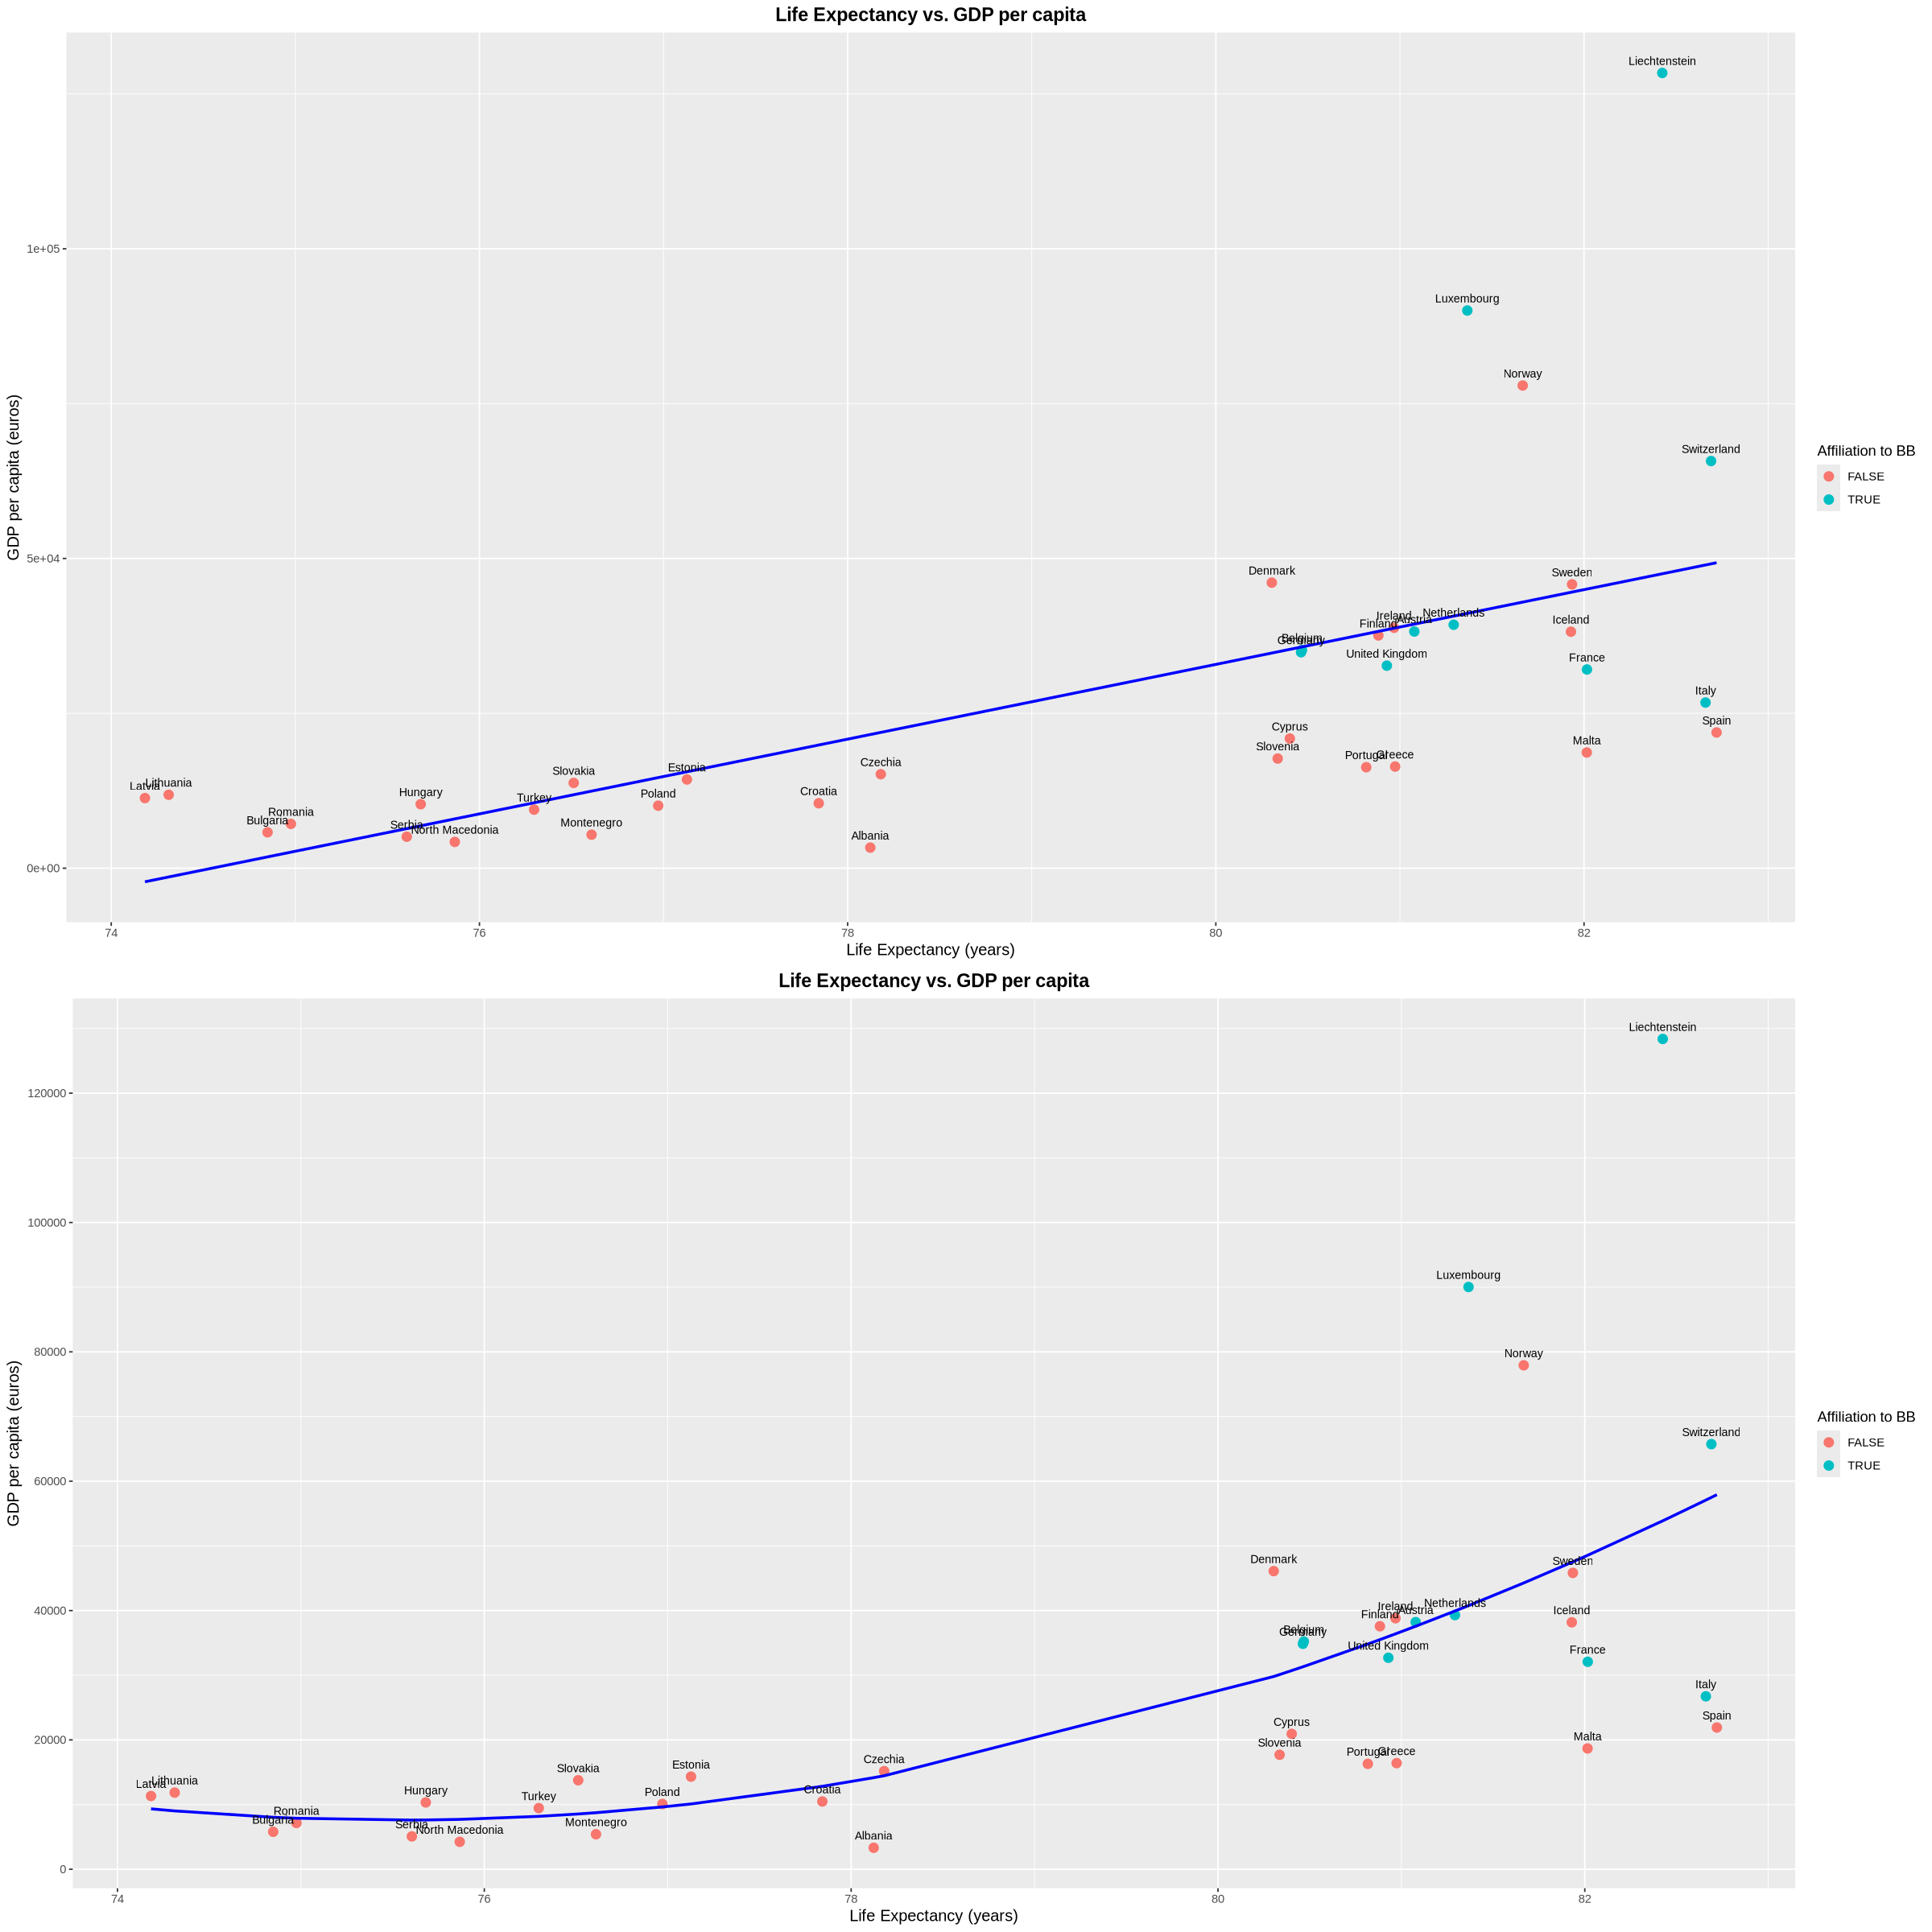

In [43]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(le_lin_plot, le_poly_plot, nrow=2)

Visually, the data have some non-linear trend, the polynomal model describes target variable better, hence we get better scores. 

#### Education Index

In [44]:
fit_ei_lin <- lm(GDPpc~EI, data=data)
print_r_squared_scores(fit_ei_lin, "Linear")

fit_ei_poly <- lm(GDPpc~poly(EI, 2), data=data)
print_r_squared_scores(fit_ei_poly, "Polynomial")

Linear:
R-squared: 0.1057 
Adjusted R-squared: 0.0802 

Polynomial:
R-squared: 0.118 
Adjusted R-squared: 0.0661 



Polynomial regression with this feature negatively impacts adjusted R-squared score, more than positively impacts the non-adjusted R-squared score.

In [45]:
ei_lin_plot <- get_model_plot(fit_ei_lin, data$EI, labs_ei)
ei_poly_plot <- get_model_plot(fit_ei_poly, data$EI, labs_ei)

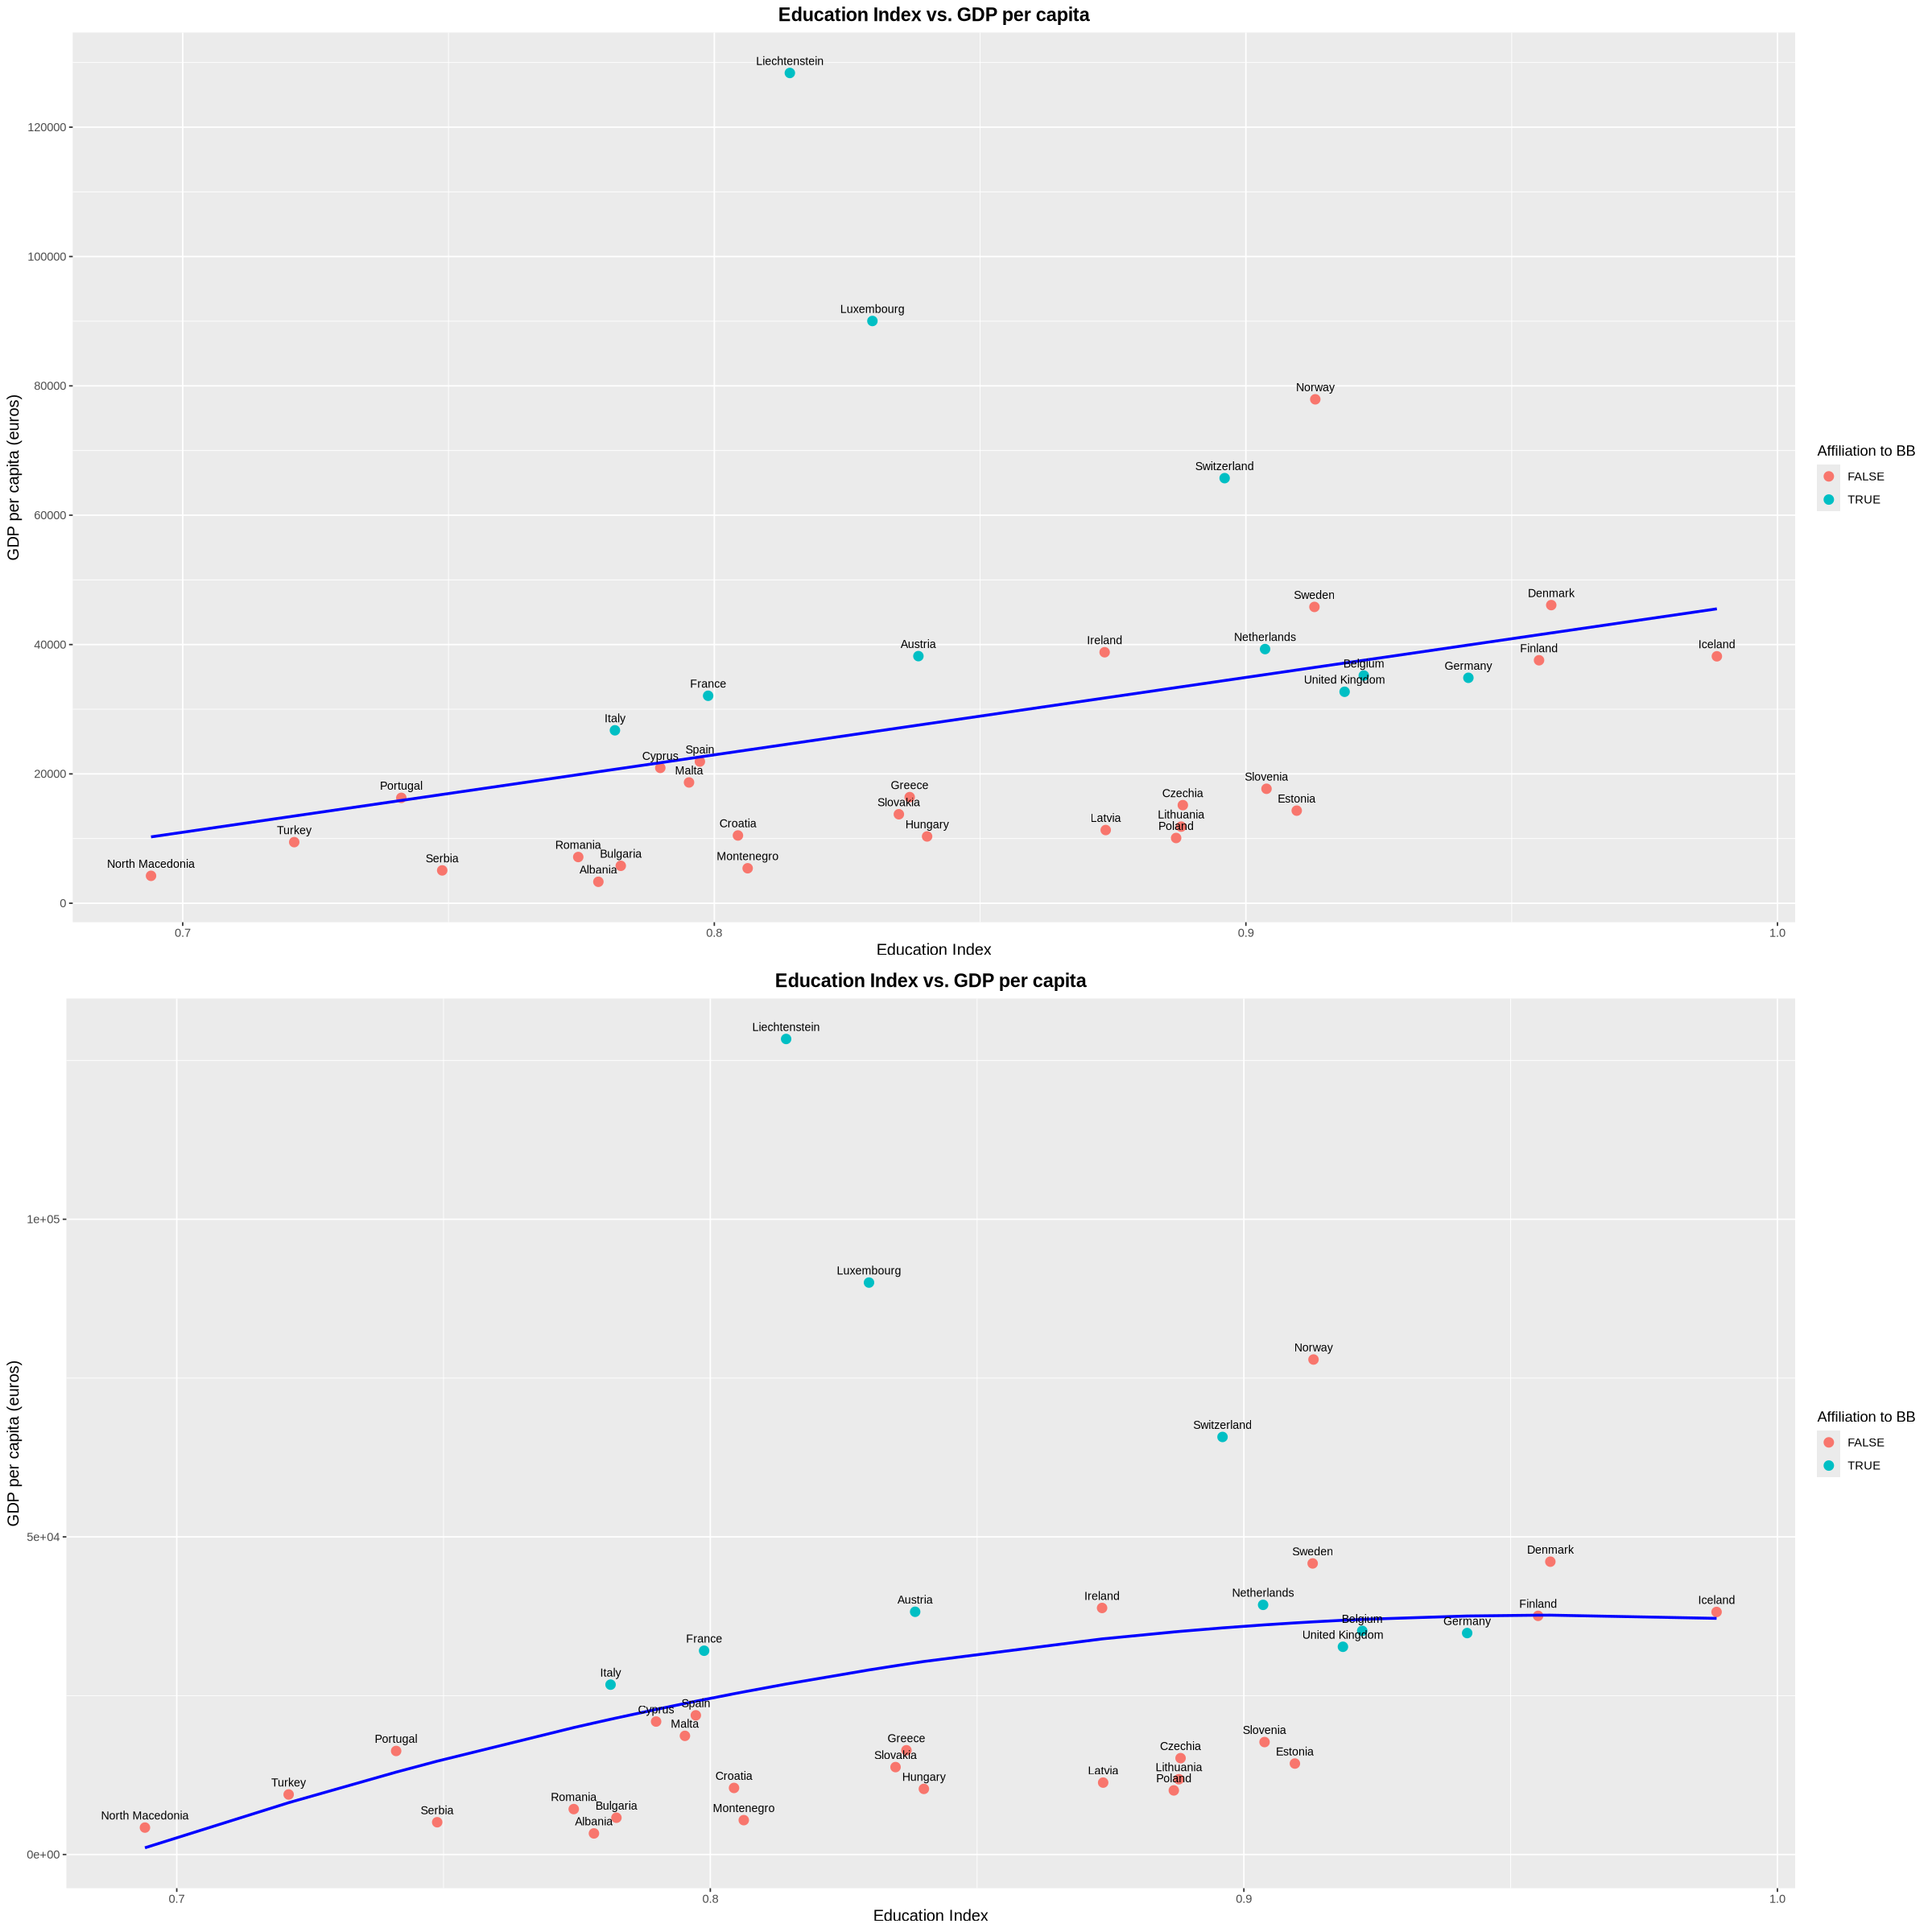

In [46]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(ei_lin_plot, ei_poly_plot, nrow=2)

Visually, the data have more linear trend, though polynomial function is affected by outliers above the curve, which is pulled up by their influence. Linear curve is a much better fit, because it follows the main trend of the data and is not affected much by the outliers.

#### Net Factor Income from Abroad per capita

In [47]:
fit_nfiapc_lin <- lm(GDPpc~NFIApc, data=data)
print_r_squared_scores(fit_nfiapc_lin, "Linear")

fit_nfiapc_poly <- lm(GDPpc~poly(NFIApc, 2), data=data)
print_r_squared_scores(fit_nfiapc_poly, "Polynomial")

Linear:
R-squared: 0.9384 
Adjusted R-squared: 0.9366 

Polynomial:
R-squared: 0.9462 
Adjusted R-squared: 0.943 



There is a minor improvement of scores by using polynomial function.

In [48]:
nfiapc_lin_plot <- get_model_plot(fit_nfiapc_lin, data$NFIApc, labs_nfiapc)
nfiapc_poly_plot <- get_model_plot(fit_nfiapc_poly, data$NFIApc, labs_nfiapc)

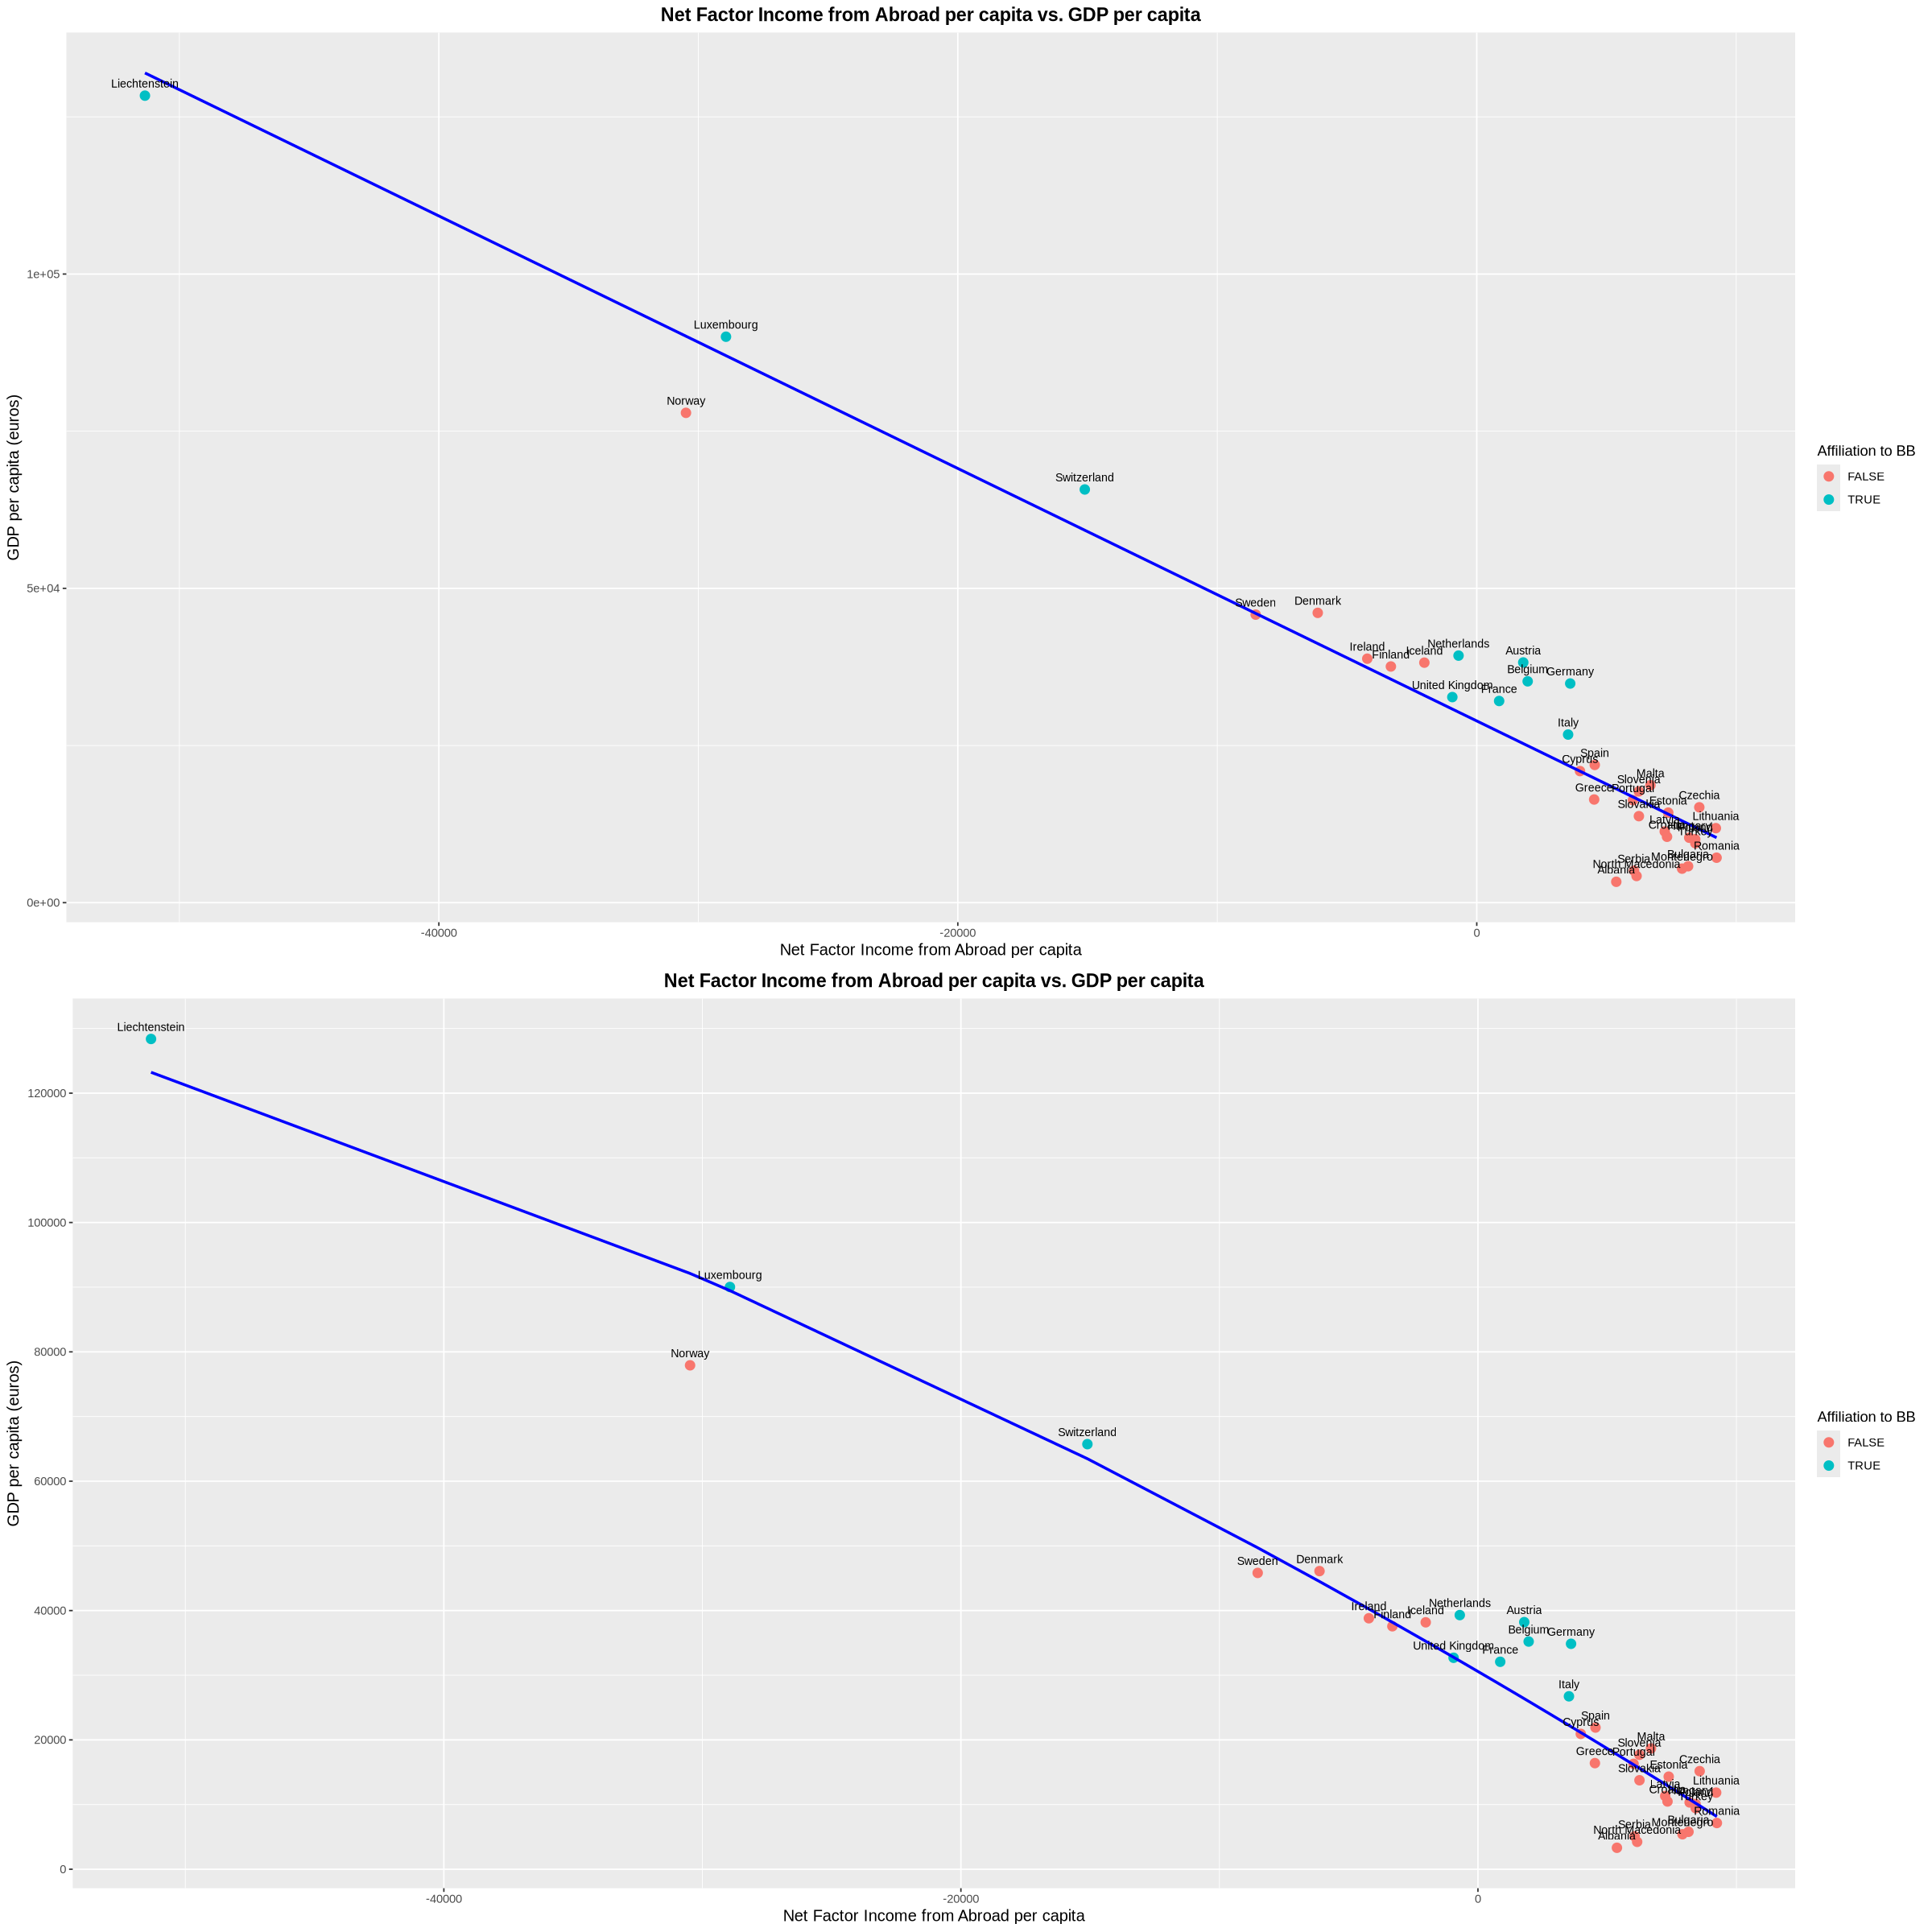

In [49]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(nfiapc_lin_plot, nfiapc_poly_plot, nrow=2)

There is some non-linear trend in the lower right part, which though cannot be described by the polynomial function. Still, polynomial curve better fits the data than the linear straight line.

### Baseline Model

Now we will decide which model we will use as a baseline for further analysis and final model selection.

Considering our earlier intuitions about some positive impacts on model performance by using polynomial functions with **Life Expectancy** and **Net Factor Income from Abroad**, we will use this function on both features in the compound model.

In [50]:
fit_poly <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data)
summary(fit_poly)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9204.4 -1564.2    89.4  2276.2  5689.3 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -10460       8375  -1.249  0.22136    
poly(LE, 2)1        17206       5395   3.190  0.00333 ** 
poly(LE, 2)2         3784       3850   0.983  0.33348    
EI                  43527       9852   4.418  0.00012 ***
poly(NFIApc, 2)1  -131100       4815 -27.228  < 2e-16 ***
poly(NFIApc, 2)2     5034       4696   1.072  0.29224    
BB_entryTRUE         8021       1623   4.943 2.74e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3676 on 30 degrees of freedom
Multiple R-squared:  0.9839,	Adjusted R-squared:  0.9807 
F-statistic: 306.1 on 6 and 30 DF,  p-value: < 2.2e-16


In [51]:
print_r_squared_scores(fit_lin, "Simple linear model scores")

Simple linear model scores:
R-squared: 0.9828 
Adjusted R-squared: 0.9807 



In comparison with the simple linear model, the scores are almost identical. Though the model is more complex, the adjusted R-squared score didn't change.

Now we will try a model with polynomial functions and interactions:

In [52]:
fit_poly_int <- lm(GDPpc ~ poly(LE, 2) * EI * poly(NFIApc, 2) * BB_entry, data = data)
print_r_squared_scores(fit_poly_int, "Model with polynoial functions and interactions")

Model with polynoial functions and interactions:
R-squared: 0.9957 
Adjusted R-squared: 0.9827 



Model is overfitted, and some coefficients are undefined, probably because of collinearity between interactions or lack of data. 

Removing problematic interactions we get this model:

In [53]:
fit_poly_int_reduced <- lm(GDPpc ~
                            (poly(LE, 2) * EI * poly(NFIApc,2)) +
                            BB_entry + 
                            BB_entry * (poly(LE, 2) + poly(NFIApc,2) + EI) +
                            BB_entry * poly(LE, 2) * EI,
                            data = data)
print_r_squared_scores(fit_poly_int_reduced, "Polynomial functions with reduced interactions")

Polynomial functions with reduced interactions:
R-squared: 0.9952 
Adjusted R-squared: 0.9843 



Adjusted R-squared slightly improved. Still, the model is very complex.

As our baseline model we will choose the model with polynomial features without interactions. This model considers our intuition about the non-linearity, isn't as complex as model with interactions, has identical scores as the simple linear model and in submodel selection process still can be reduced to the simple linear model.

In [54]:
baseline <- fit_poly

## Outliers

We explore influential data points that are:
- outliers - prediction values don't follow the main trend.
- leverages - data points that may follow the trend, but they lie far away from the main clusters of data.
- both outliers and leverages.

We will start with exploring outliers in the data, then we will use Cook's Distance metric to determine outliers.

### Data Analysis

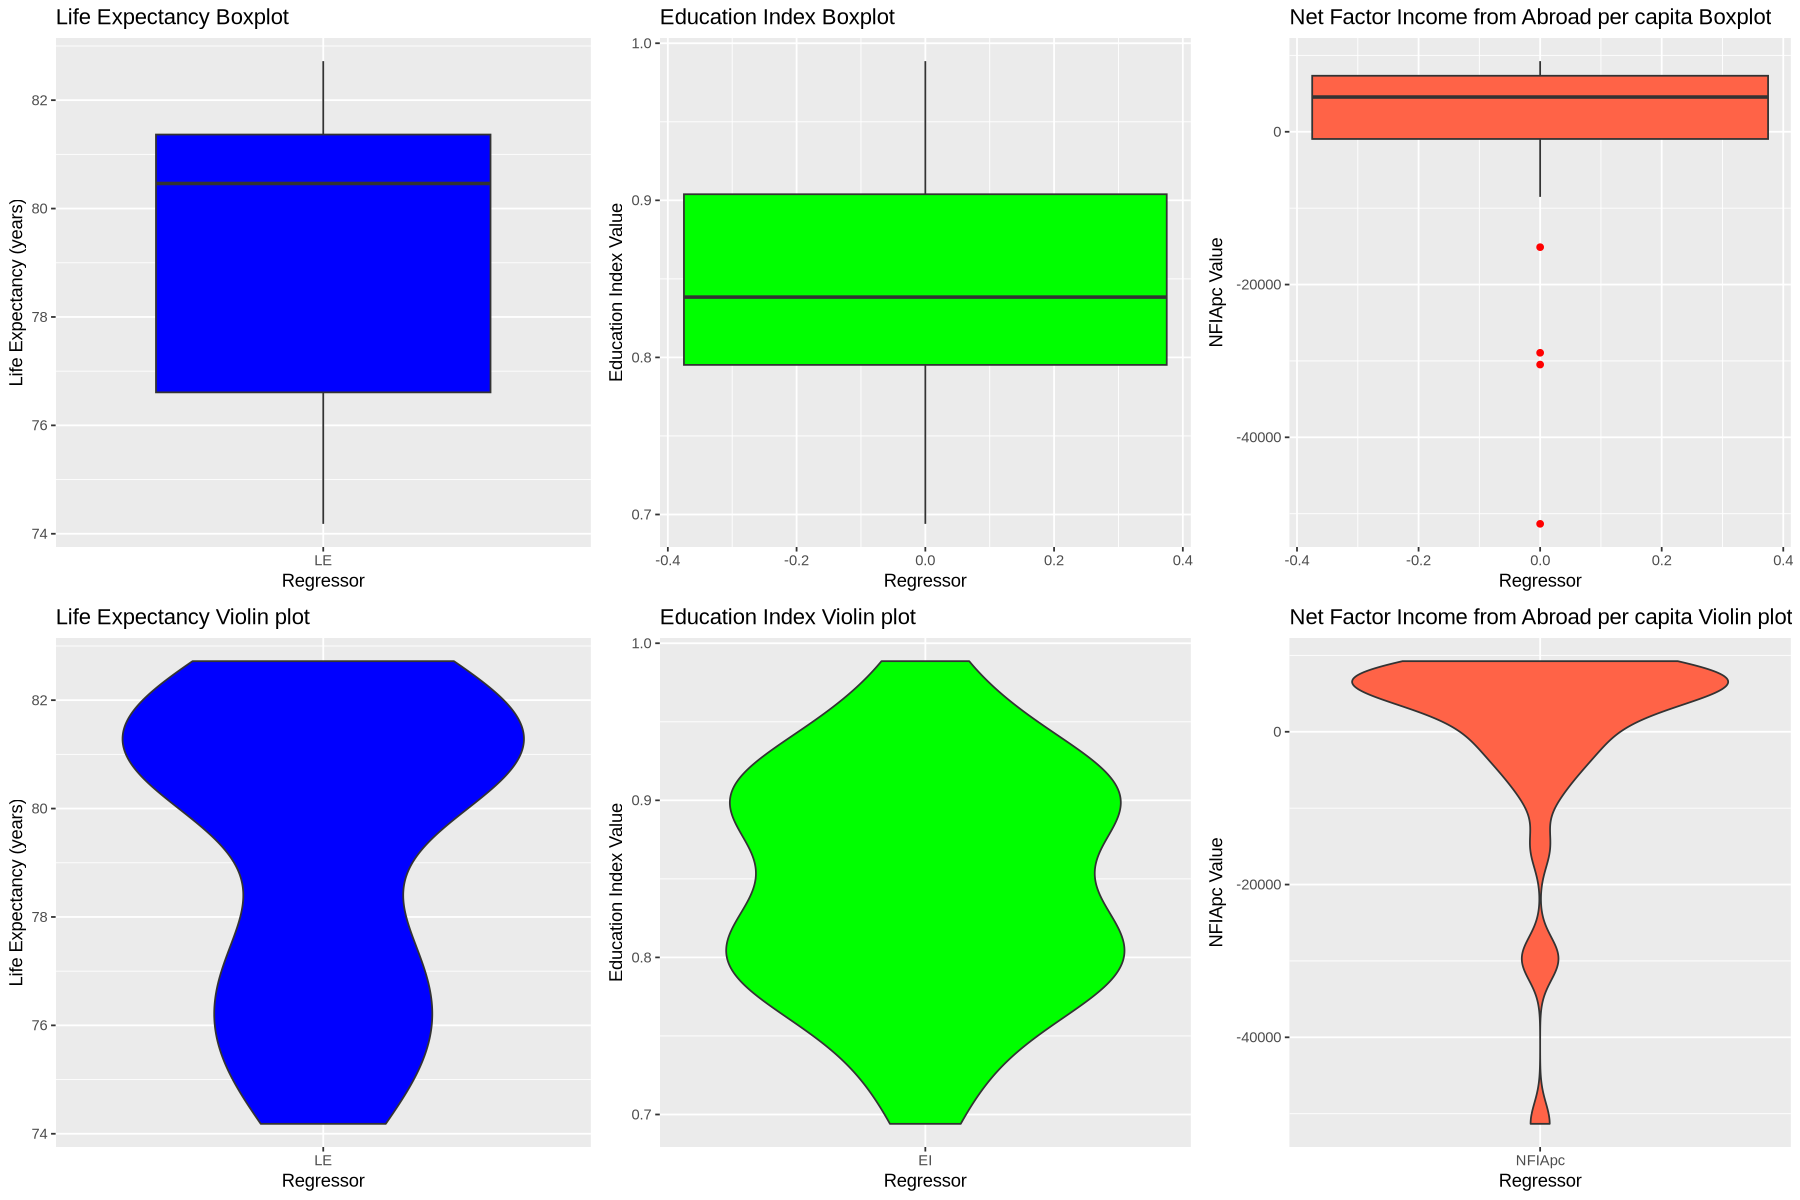

In [55]:
# set up plot size
options(repr.plot.width = 15, repr.plot.height=10)

# Create individual ggplots for each regressor

boxplot_LE <- ggplot(data, aes(x="LE", y=LE)) + 
    geom_boxplot(fill="blue", outlier.color="red") +
    labs(title="Life Expectancy Boxplot", x="Regressor", y="Life Expectancy (years)")
violin_LE <- ggplot(data, aes(x="LE", y=LE))+
    geom_violin(fill= "blue") +
    labs(title="Life Expectancy Violin plot", x="Regressor", y="Life Expectancy (years)")

boxplot_EI <- ggplot(data, aes(y=EI)) + 
    geom_boxplot(fill="green", outlier.color="red") +
    labs(title="Education Index Boxplot", x="Regressor", y="Education Index Value")
violin_EI <- ggplot(data, aes(x="EI", y=EI)) +
    geom_violin(fill= "green") + 
    labs(title="Education Index Violin plot", x="Regressor", y="Education Index Value")

boxplot_NFIApc <- ggplot(data, aes(y=NFIApc)) + 
    geom_boxplot(fill="tomato", outlier.color="red") +
    labs(title="Net Factor Income from Abroad per capita Boxplot", x="Regressor", y="NFIApc Value")
violin_NFIApc <- ggplot(data, aes(x="NFIApc", y=NFIApc)) +
    geom_violin(fill= "tomato") +
    labs(title="Net Factor Income from Abroad per capita Violin plot", x="Regressor", y="NFIApc Value")

# Arrange the plots in a grid
plot_grid(boxplot_LE, boxplot_EI, boxplot_NFIApc,
             violin_LE, violin_EI, violin_NFIApc,
             nrow = 2, ncol = 3)
             

**Net Factor Income from Abroad per capita** has some influential points. Looking at the scatter plot **Net Factor Income from Abroad per capita vs. GDP per capita**, we can observe that those data points follow the trend, but lie far away from the main clusters of data, meaning that they are leverages, but not outliers.

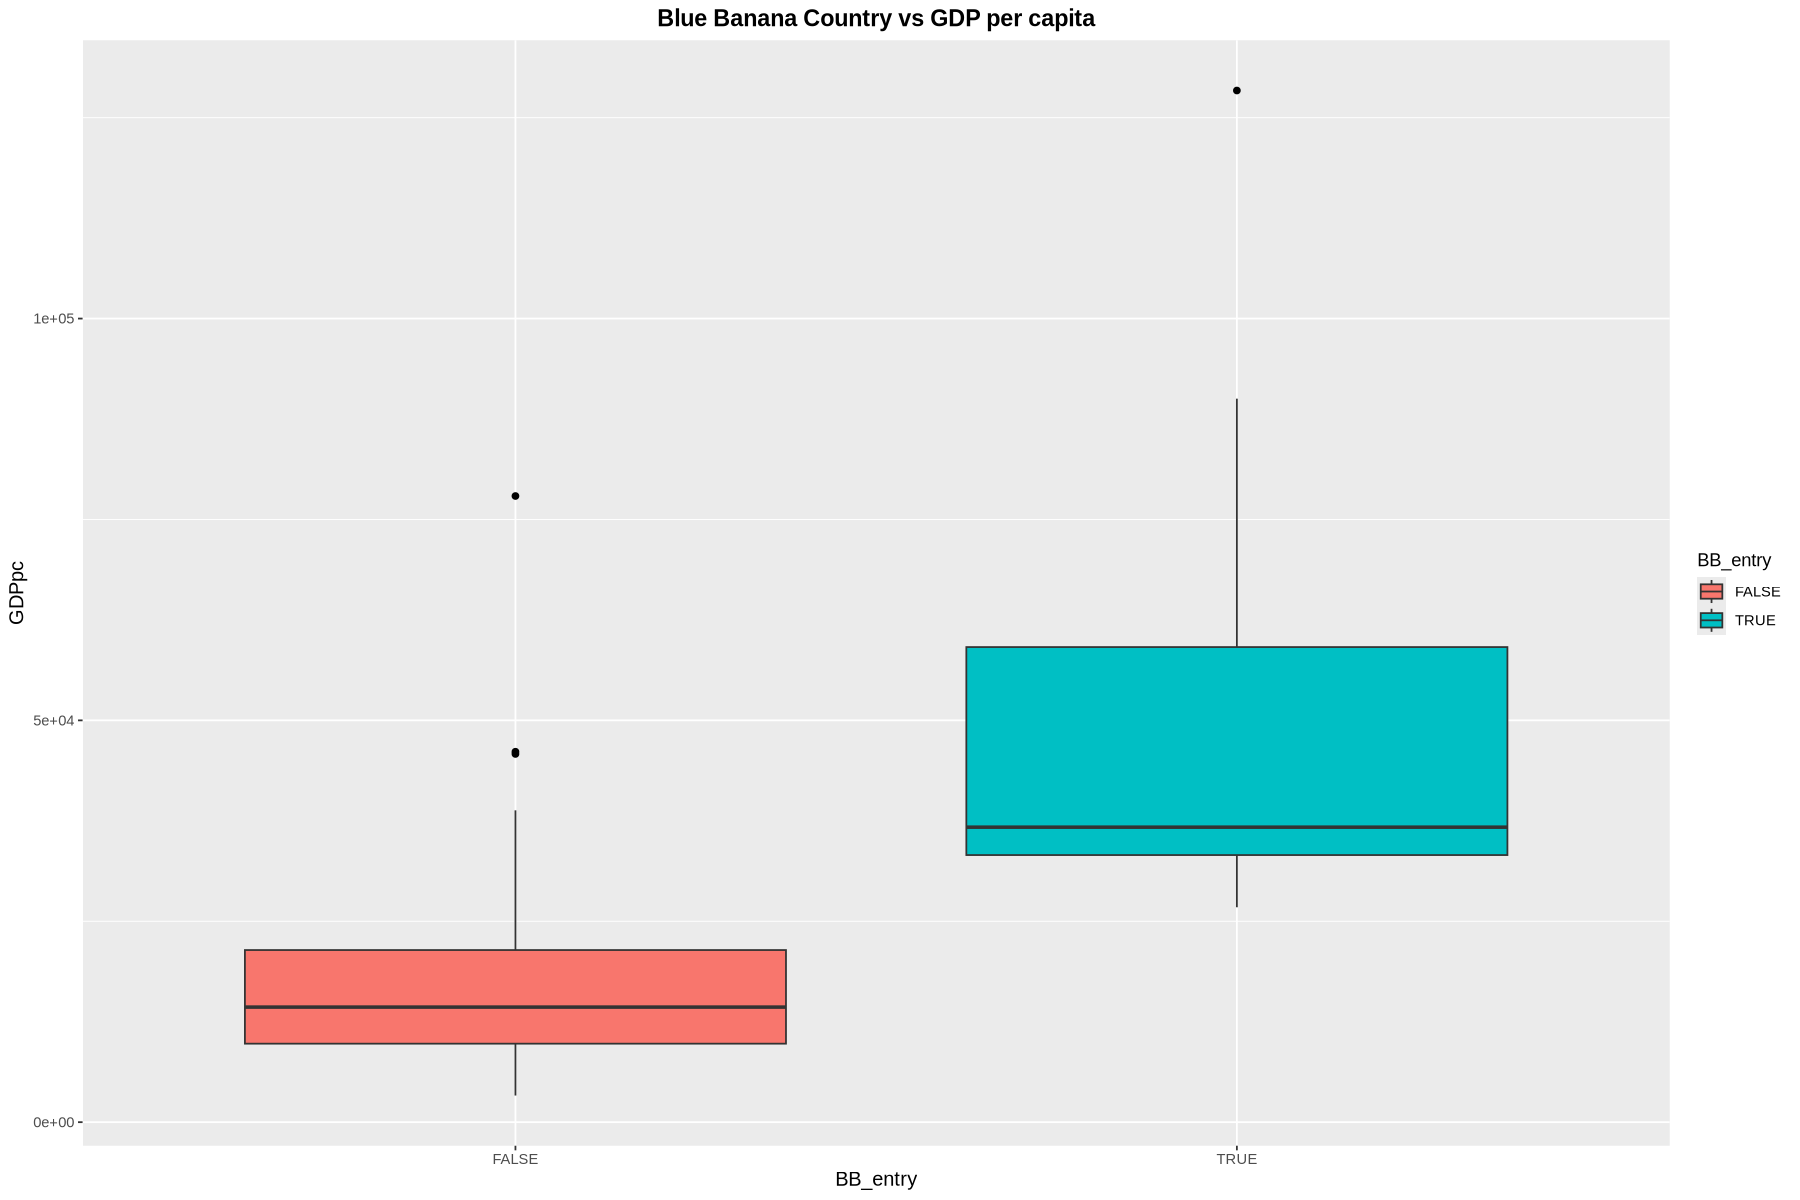

In [56]:
ggplot(data, aes(x=BB_entry, y=GDPpc, fill=BB_entry)) +
  geom_boxplot(outlier.color='black') +
  labs(title="Blue Banana Country vs GDP per capita") +
  theme

In the group of Blue Banana states, we see the **Liechtenstein** outlier, which has remarkably high GDPpc value. 

In the group of non-BB states, **Norway** (the farthest), **Denmark** and **Sweden** (the last two lie almost in the same place, overlapping each other) are the outliers.

Observing scatterplots - **Life Expectancy vs. GDP per capita** and **Education Index vs. GDP per capita** we see the most significant outliers:
 - Lichtensteing
 - Luxemburg
 - Norway


### Cook's Distance

Though we have some intuition about outliers from visual information above, we should remember, that we work with higher dimensionality and we cannot say exactly how our suspects behave there. Thus we will use the Cook's Distance metric to determine outliers:

$$
D_i = \frac{\sum_{j=1}^n (\hat{Y}_j - \hat{Y}_{j(i)})^2}{k \frac{S_e}{n-k}},
$$

where $k$ is number of regressors, $n$ is the number of observations, $S_e$ is residual sum of squares, $\hat{Y}_j$ is prediction of $Y_j$ and $\hat{Y}_{j(i)}$ si prediction of $Y_j$ with removing the $i$-th data point.

We remove the i-th data point and look at the distance value. The higher is the distance, the more influential is the data point.

To determine the cutoff value there are different methods, we will use the default $\frac{4}{n}$ formula.

In [57]:
# plots sizes
options(repr.plot.width=15, repr.plot.height=10)

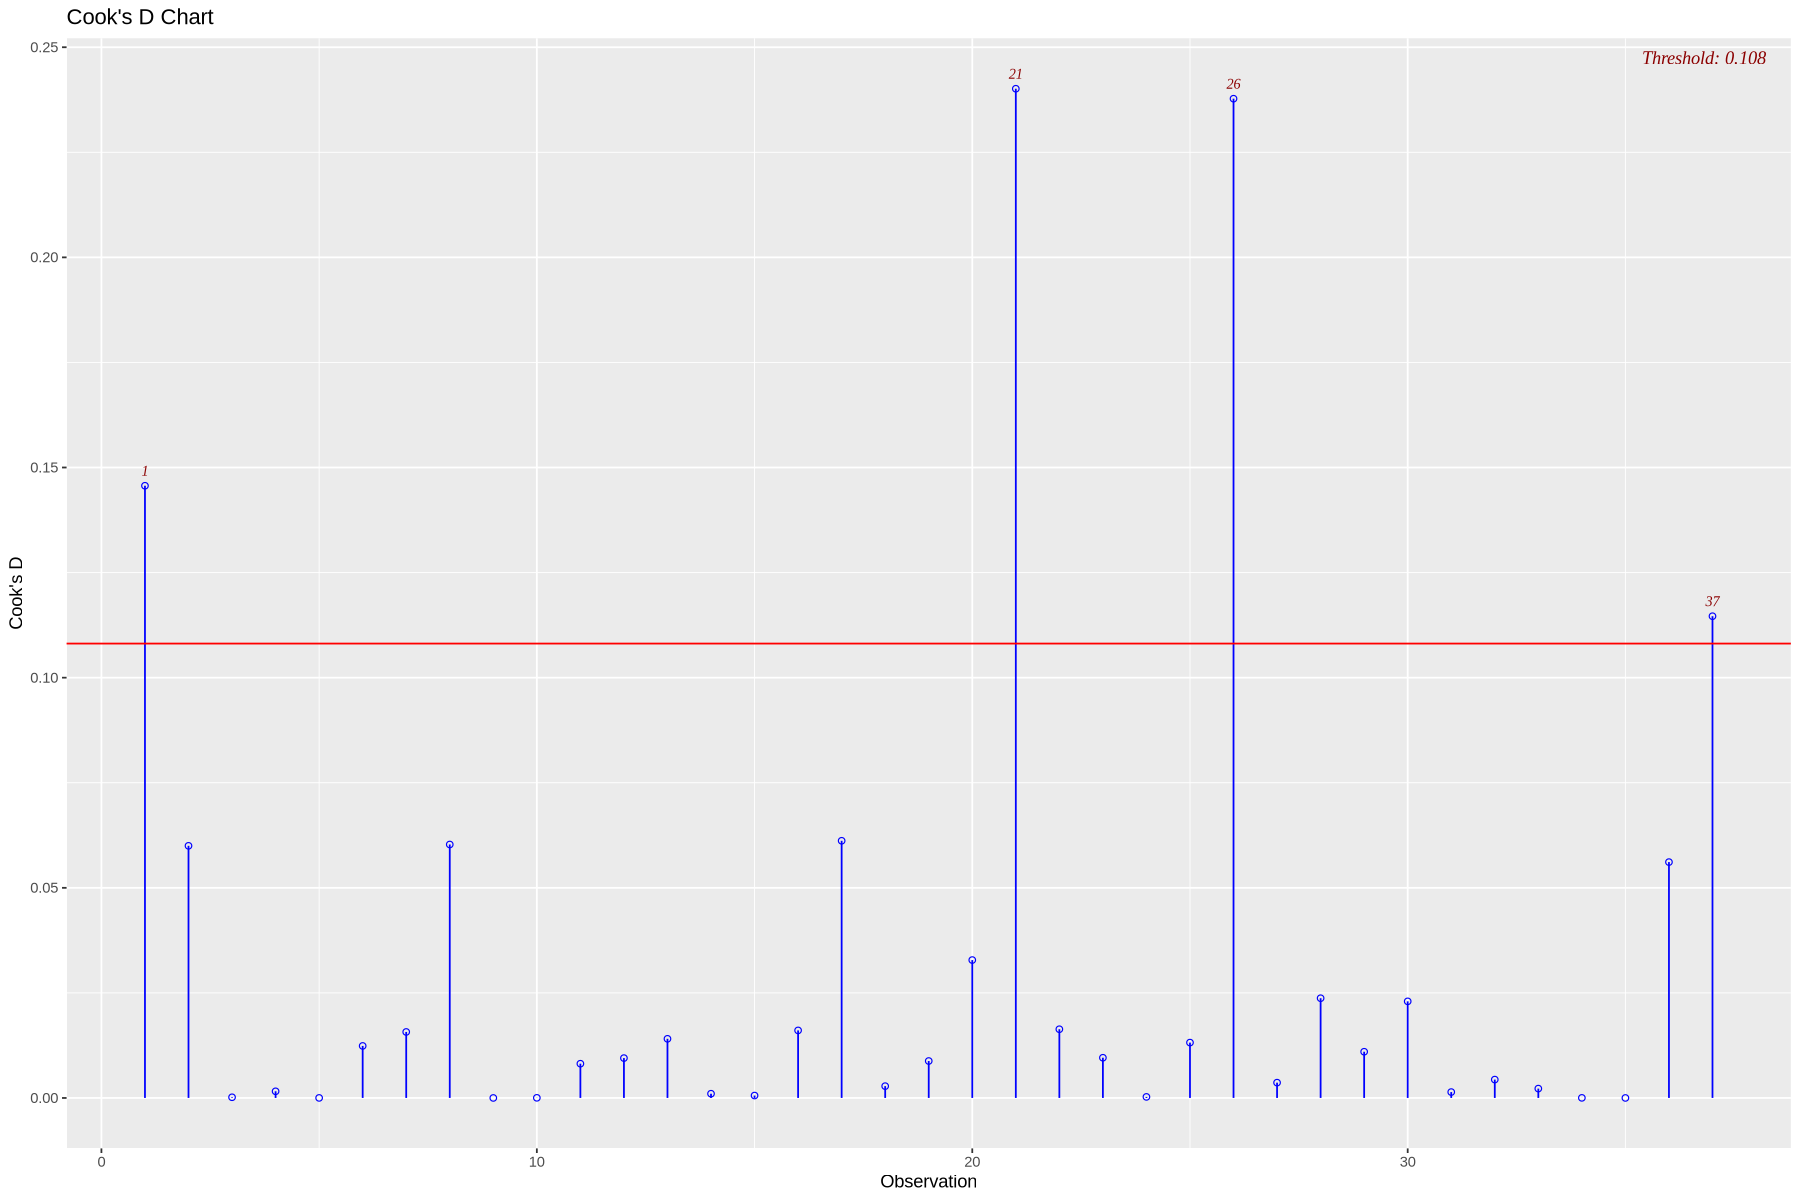

In [58]:
ols_plot_cooksd_chart(baseline)

In [59]:
data[c(21, 26, 1, 37),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
21,Luxembourg,90030,81.366,0.8297409,-28933.9761,TRUE
26,Norway,77920,81.667,0.9130506,-30476.4766,FALSE
1,Albania,3320,78.123,0.7781896,5376.9032,FALSE
37,United Kingdom,32700,80.929,0.9185661,-941.5821,TRUE


The **Luxembourg** and **Norway** both are very influential outliers.

Using Cook' distance metric, we iteratively identified the most influential outliers in this order:
1. **Luxembourg**
2. **Liechtenstein**
3. **Norway**

They match our intiution from the visual information.

Though still there exist data points with Cook's distance above the threshold, we will not remove them, because we don't want to reduce dataset size further and the first three removed data points had support from our intuition.

In [60]:
data_filtered <- data[-c(19, 21, 26, 35),] # remove observation
row.names(data_filtered) <- NULL # reset indexes
baseline <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data_filtered)
print_r_squared_scores(baseline, "Baseline model scores after outliers removal")

Baseline model scores after outliers removal:
R-squared: 0.9465 
Adjusted R-squared: 0.9341 



By removing outliers, performance of our model decreased, but same decrease can be seen with the simple linear model.

## Multicollinearity

To test multicollinearity we will use the VIF (Variance Inflation Factor) method.

In [61]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)
vif_scores <- vif(model)
print(vif_scores)

      LE       EI   NFIApc BB_entry 
2.092457 1.413313 2.304383 1.258043 


The rule of thumb is:
- if $\text{VIF} > 4 $, we suspect multicollinearity and should make further inspections.
- if $\text{VIF} > 10 $, it indicates strong multicollinearity.

In our case, all VIF values are less than 4, thus we don't have multicollinearity issues.

## Model Assumptions Tests

Before we will start selection of final model, we need to check assumptions of our baseline model:

- no multicollinearity - already done in previous section
- linearity between target varibale and independent variables
- homooskedasticity of residuals
- normality of residuals
- no autocorrelation of residuals

### Linearity

The relationship between target variable and independent variables should be linear.

Earlier we have already inspected linearity between target variable and independent variables and applied polynomial transformation where non-linearity may be observed.

### Homoskedasticity

The model's residuals should be homoskedastic, hence the variace of residuals should be constant.

In [62]:
ols_test_breusch_pagan(baseline)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

              Data                
 ---------------------------------
 Response : GDPpc 
 Variables: fitted values of GDPpc 

        Test Summary         
 ----------------------------
 DF            =    1 
 Chi2          =    0.4624296 
 Prob > Chi2   =    0.4964907 

The test fails to reject the null hypothesis that variance of residuals is constant.

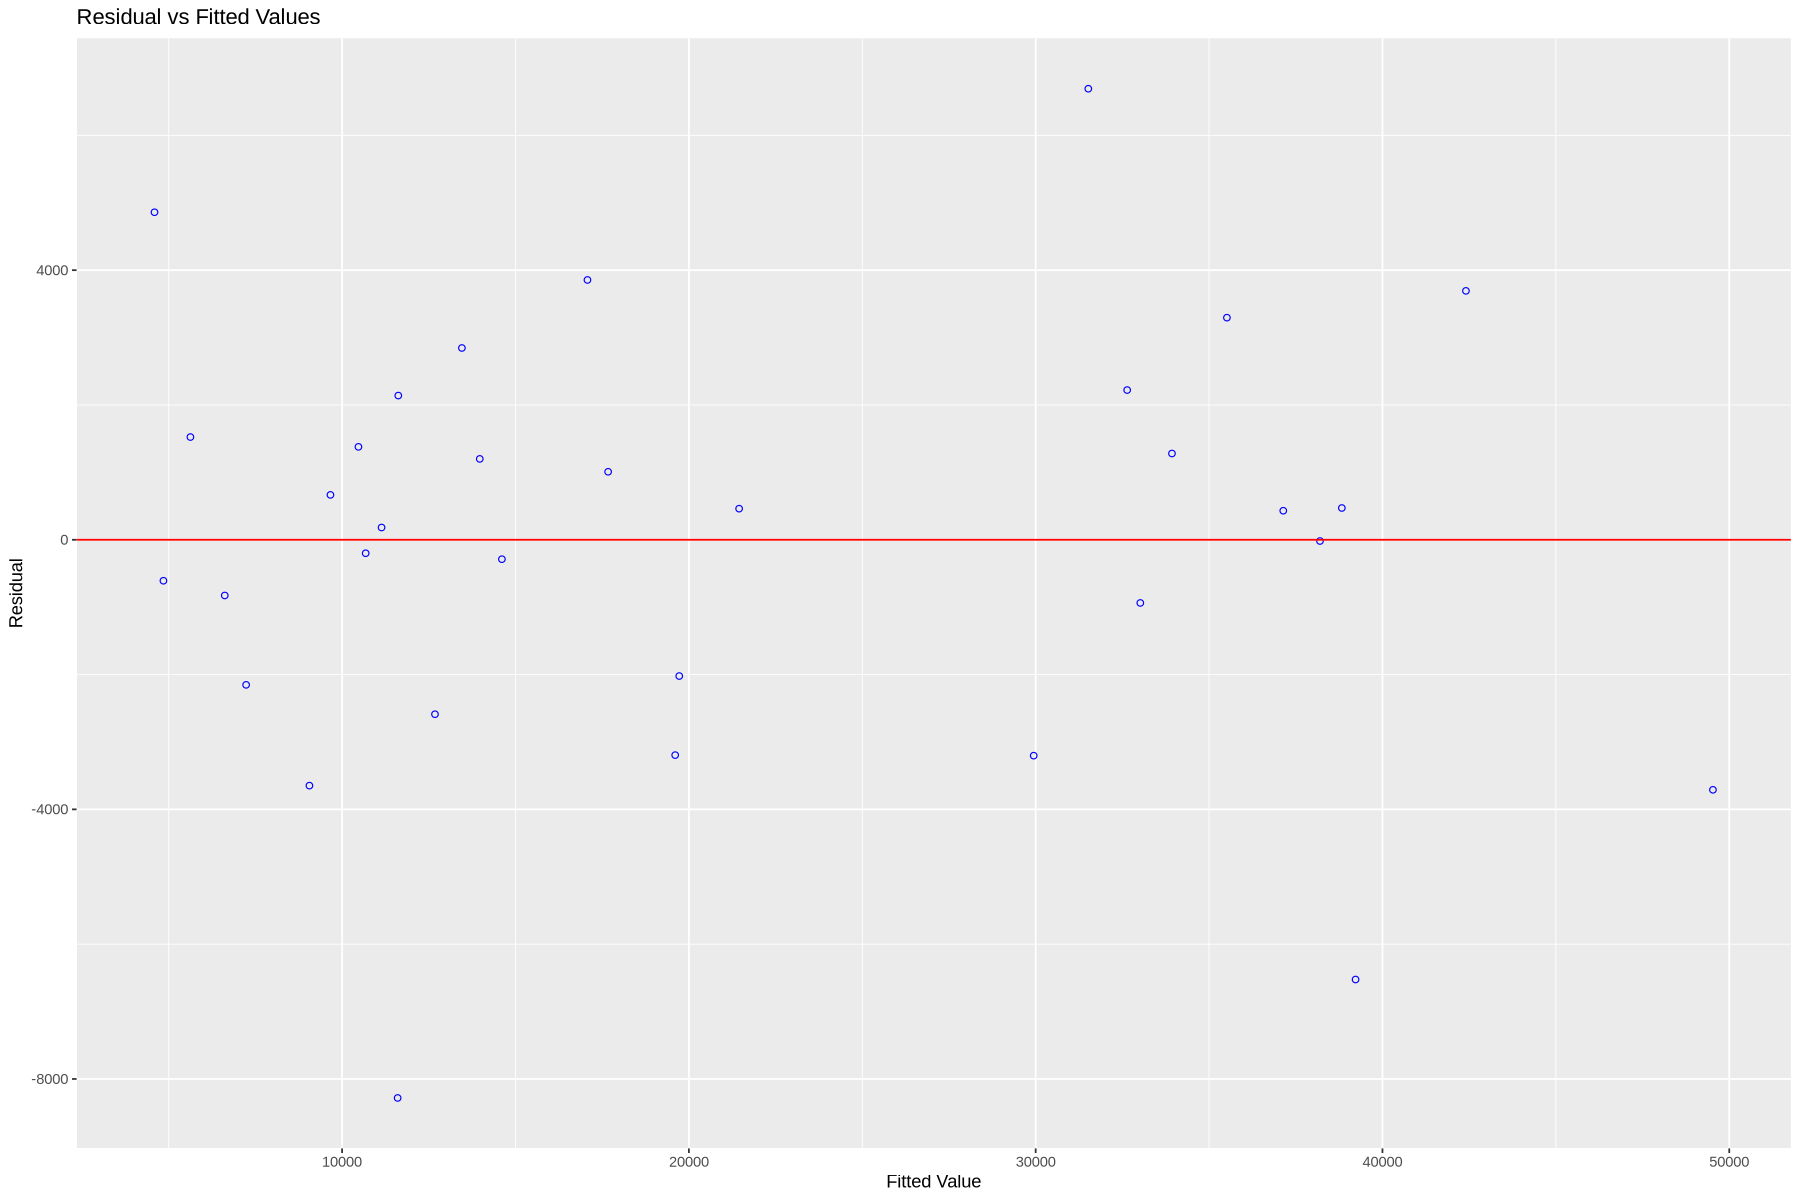

In [63]:
ols_plot_resid_fit(baseline)

Visually, there are no significant fluctuations of variance. Therefore, we will assume that our residuals are homoskedastic.

### Normality

We expect normality of residuals to rely on our model's performance.

We will use the Shapiro-Wilc test on residuals of the model:

In [64]:
shapiro.test(residuals(baseline))


	Shapiro-Wilk normality test

data:  residuals(baseline)
W = 0.97614, p-value = 0.6653


We fail to reject the null hypothesis that residuals distribution is normal.

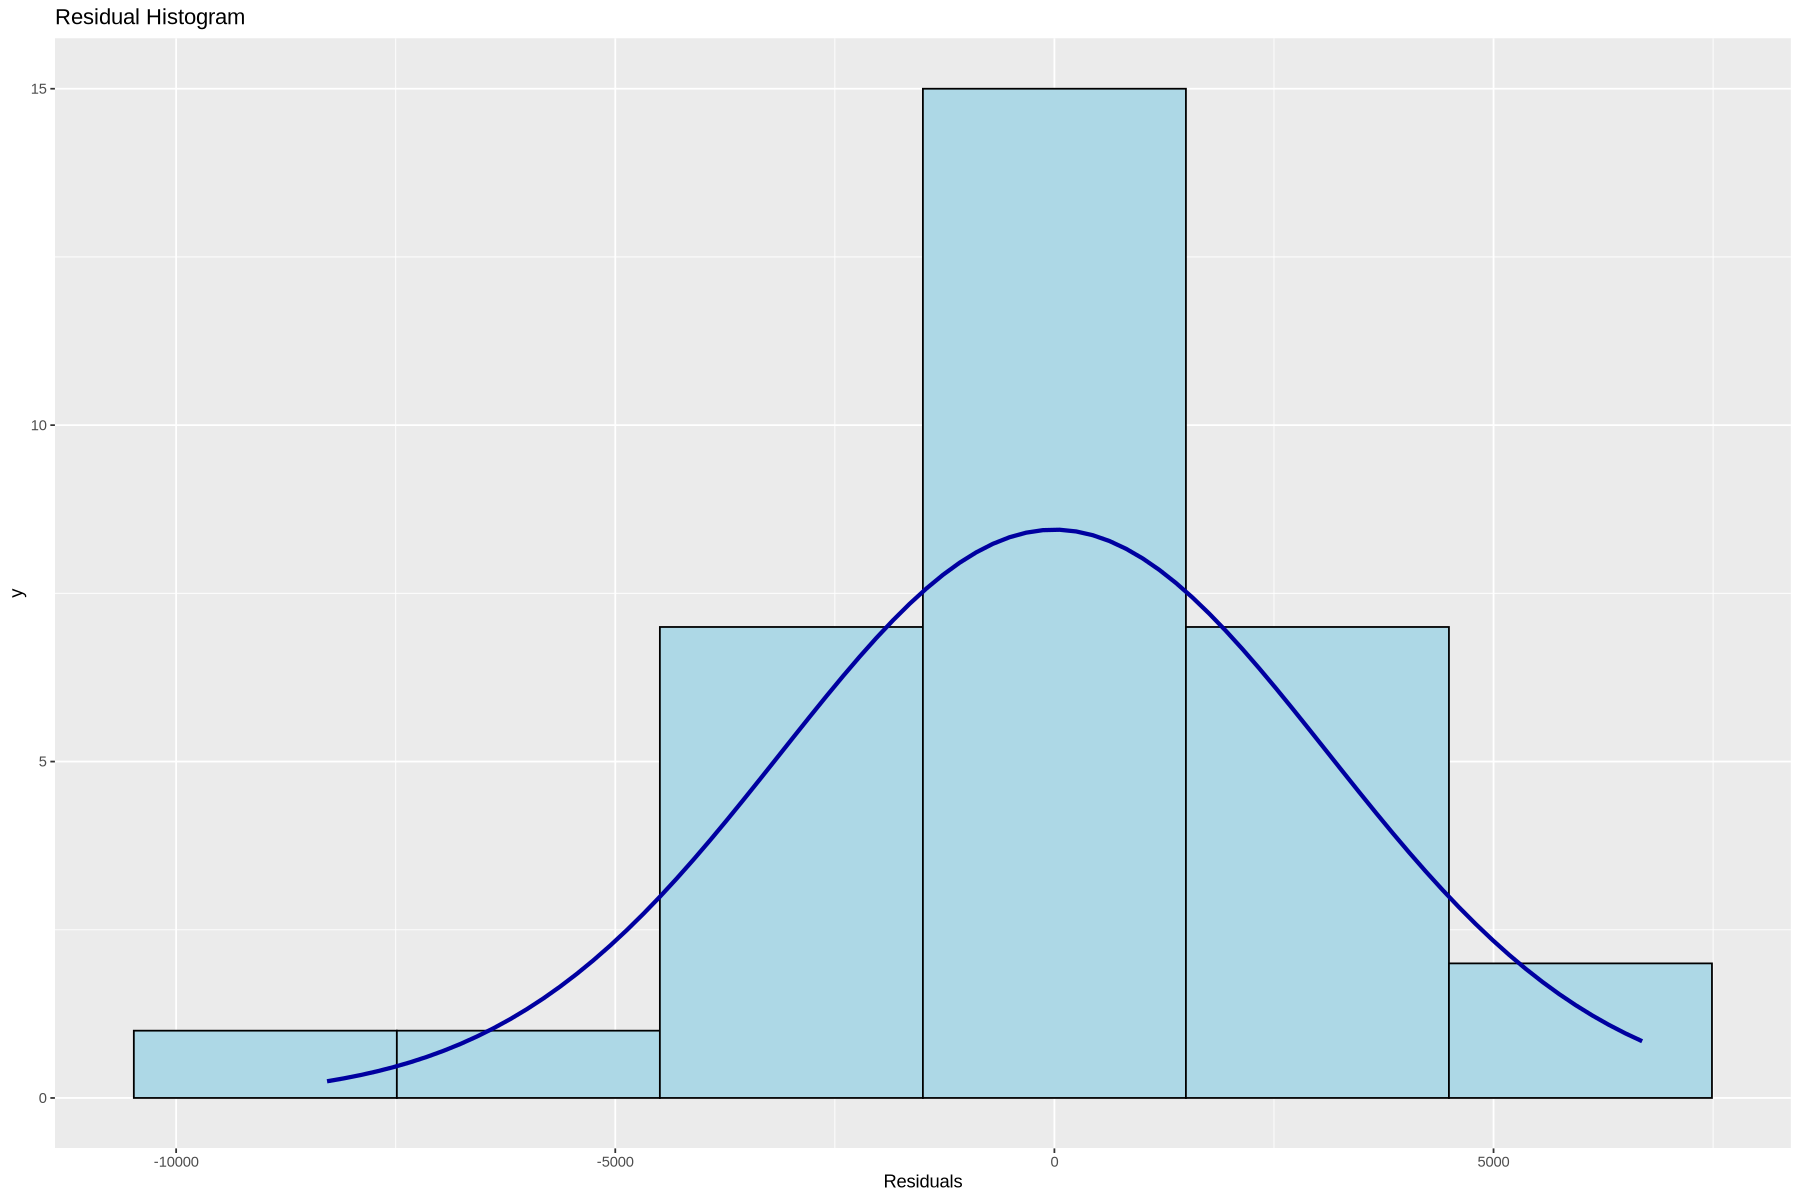

In [65]:
ols_plot_resid_hist(baseline)

Observing the histogram, we see that residuals distribution resembles normal distribution.

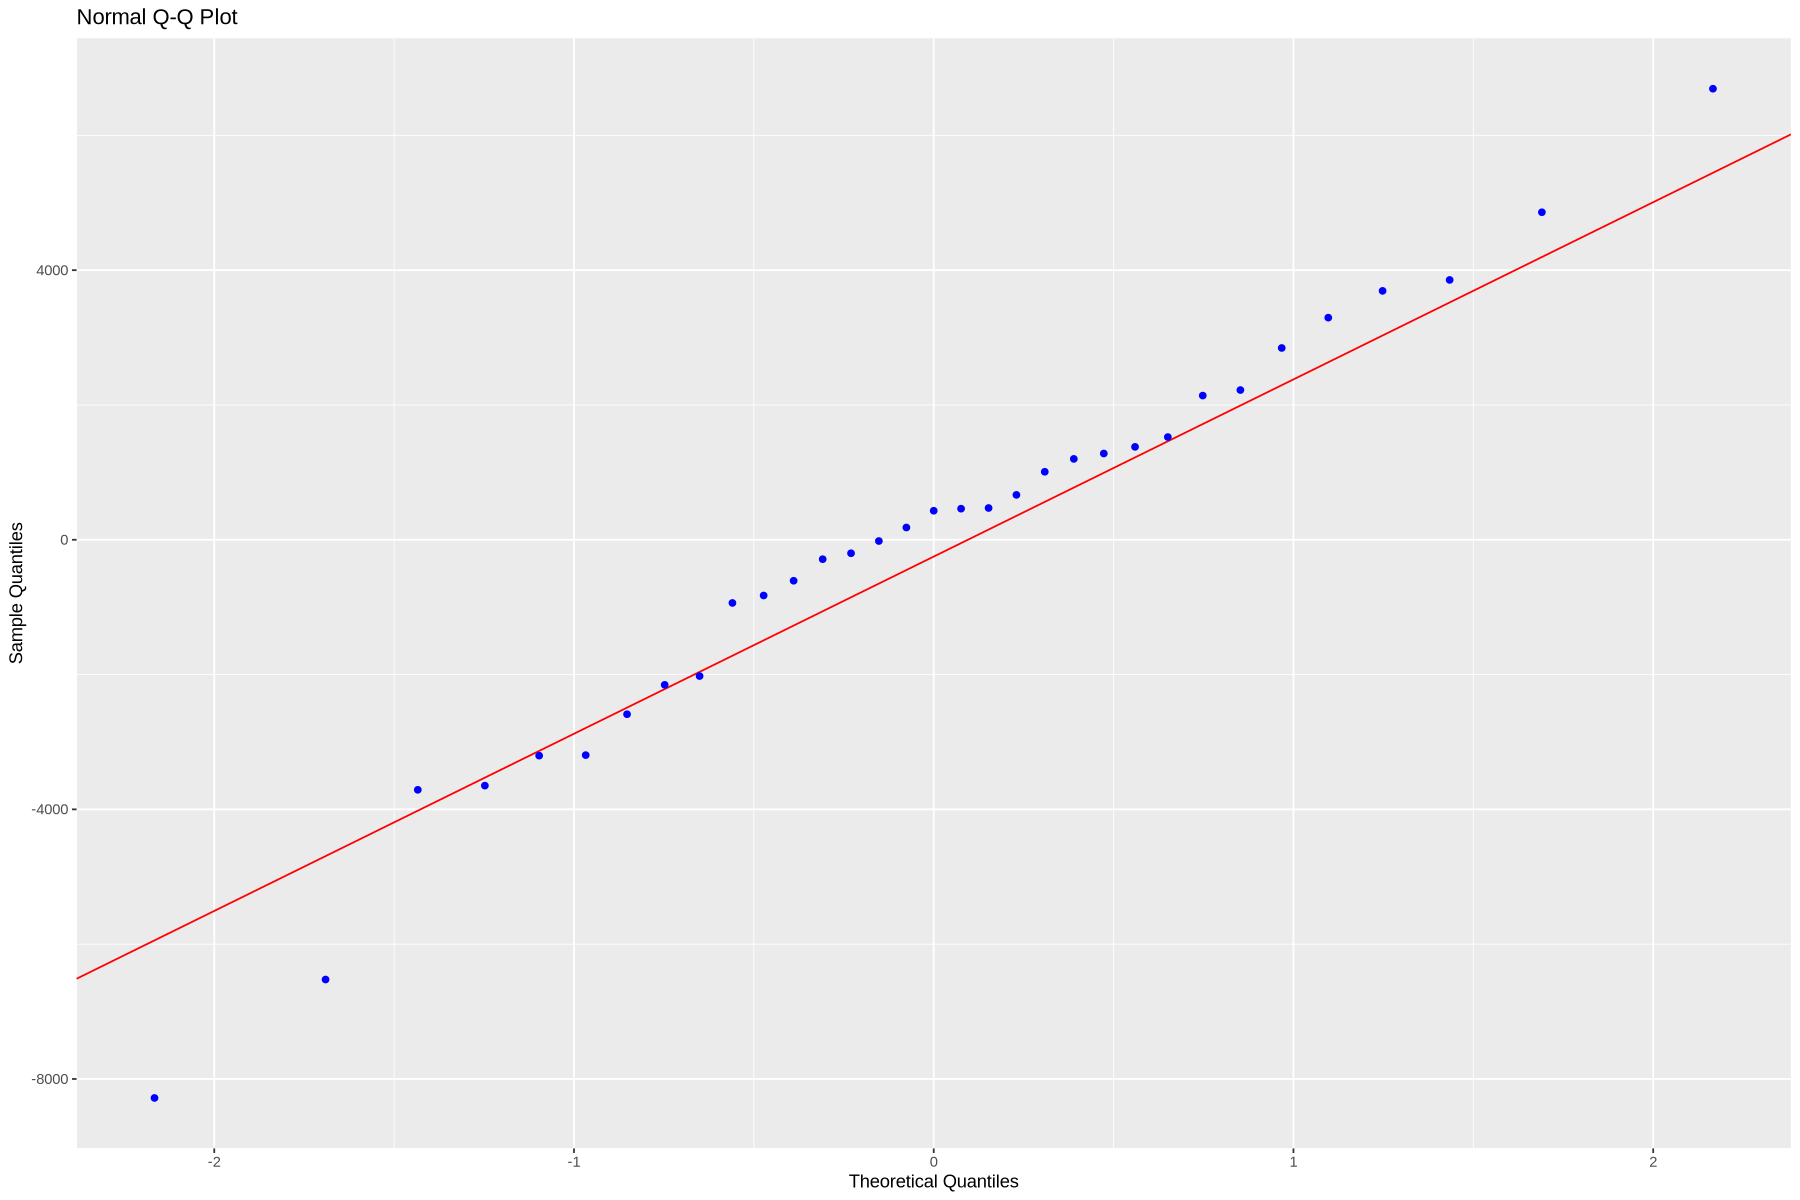

In [66]:
ols_plot_resid_qq(baseline)

Looking at the QQ plot we see that most of the data points are aligned with the line, and the outlying points are not so far from the line.

In conclusion, we will assume that residuals of our baseline model are from normal distribution.

### Autocorrelation

Because all of our data comes from the fixed year 2013, we don't have time series in our data. Thus, we don't have to conduct autocorrelation test, we can assume that there is not autocorrelation in our data.

## Final Model

As our baseline model satisfies neccessary assumptions, we can use AIC (Akaike Information Criterion) score to determine the final model.

We will use sequential method to iteratively add regressors to our final model until AIC score stops improving. After that we will check assumptions of the final model.

In [67]:
attach(data_filtered)
step(lm(GDPpc ~1),
     scope=list(lower=~1,
     upper=~LE + I(LE^2) + EI + NFIApc + I(NFIApc^2) + BB_entry))
detach(data_filtered)

Start:  AIC=628.55
GDPpc ~ 1

              Df  Sum of Sq        RSS    AIC
+ NFIApc       1 4689417479 1119892273 576.22
+ I(LE^2)      1 3341617880 2467691872 602.29
+ LE           1 3337194093 2472115658 602.35
+ EI           1 2491250958 3318058793 612.06
+ I(NFIApc^2)  1 2091519056 3717790696 615.82
+ BB_entry     1 1521979359 4287330393 620.52
<none>                      5809309752 628.55

Step:  AIC=576.22
GDPpc ~ NFIApc

              Df  Sum of Sq        RSS    AIC
+ BB_entry     1  413761068  706131205 563.00
+ I(LE^2)      1  264364419  855527854 569.33
+ LE           1  262881849  857010424 569.39
+ EI           1  254408675  865483598 569.72
+ I(NFIApc^2)  1  107355021 1012537252 574.89
<none>                      1119892273 576.22
- NFIApc       1 4689417479 5809309752 628.55

Step:  AIC=563
GDPpc ~ NFIApc + BB_entry

              Df  Sum of Sq        RSS    AIC
+ EI           1  224176852  481954353 552.40
+ I(LE^2)      1   91788526  614342679 560.41
+ LE           1  


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + I(LE^2) + I(NFIApc^2))

Coefficients:
 (Intercept)        NFIApc  BB_entryTRUE            EI       I(LE^2)  
  -6.634e+04    -1.669e+00     8.424e+03     4.354e+04     8.505e+00  
 I(NFIApc^2)  
   6.422e-05  


Best AIC score has a model with the score 542.96 with formula: GDPpc ~ NFIApc + BB_entry + EI + I(LE^2) + I(NFIApc^2):


In [68]:
final <- lm(formula = GDPpc ~ NFIApc + BB_entry + EI + I(LE^2) + I(NFIApc^2), data=data_filtered)
summary(final)


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + I(LE^2) + I(NFIApc^2), 
    data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-9022.8 -2052.3   455.5  1878.6  6488.0 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.634e+04  1.792e+04  -3.702 0.000967 ***
NFIApc       -1.669e+00  1.997e-01  -8.358 5.73e-09 ***
BB_entryTRUE  8.424e+03  1.927e+03   4.371 0.000165 ***
EI            4.354e+04  9.785e+03   4.450 0.000133 ***
I(LE^2)       8.505e+00  2.309e+00   3.683 0.001018 ** 
I(NFIApc^2)   6.422e-05  3.809e-05   1.686 0.103329    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3447 on 27 degrees of freedom
Multiple R-squared:  0.9448,	Adjusted R-squared:  0.9346 
F-statistic: 92.39 on 5 and 27 DF,  p-value: 4.106e-16


The I(NFIApc^2) coefficient seems to be insignificant, and we had intuition, that polynomial function on the NFIApc may not be very helpful. Also, this model's assumptions are satisfied, normality and homoscedasticity are not rejected. We will remove the insignificant coefficient.

In [69]:
final <- lm(formula = GDPpc ~ NFIApc + BB_entry + EI + I(LE^2), data=data_filtered)
summary(final)


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + I(LE^2), data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-10142.6  -1474.6    250.2   2269.2   6361.6 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.420e+04  1.694e+04  -3.200 0.003407 ** 
NFIApc       -1.606e+00  2.025e-01  -7.930 1.23e-08 ***
BB_entryTRUE  6.738e+03  1.701e+03   3.962 0.000465 ***
EI            4.545e+04  1.003e+04   4.529 0.000100 ***
I(LE^2)       6.706e+00  2.115e+00   3.172 0.003657 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3559 on 28 degrees of freedom
Multiple R-squared:  0.939,	Adjusted R-squared:  0.9302 
F-statistic: 107.7 on 4 and 28 DF,  p-value: < 2.2e-16


R-squared scores slightly decreased, but such changes are not significant, model is less complex and describes data very well, assumptions are again satisfied, so we can rely on model's performance. 

This model will be our final model.

**Results interpretation:**
- **Intercept:** -54200 - predicted value of GDPpc when all independent variables are zero.
- **NFIApc (Net Factor Income from Abroad per capita):** -1.606 - for each unit increase in net foreign income per capita, GDPpc is expected to decrease by 1.606 units
- **BB_entryTRUE:** 6738 - if BB_entry is TRUE, GDPpc is expected to increase by 6738 units compared to when BB_entry is FALSE.
- **EI (Education Index):** 45450 - for each unit increase in the education index, GDPpc is expected to increase by 45450 units
- **LE (Life Expectancy):** 6.708 - the change is not constant, but polynomial. For each additional unit of $\text{LE}^2$, GDPpc is expected to increase by 6.708 units, or given the current $\text{LE}$ value, increasing it by 1 unit, we increase the GDPpc by $ 6.708 \cdot ( 2 \cdot \text{LE} + 1 )$ units.
- **Adjusted R-squared:** 0.9302 - 93.02% of the variability is explained, suggesting a very good model fit.

**Conclusion:**

The regression analysis shows that all independent variables (LE^2, EI, NFIApc, and BB_entry) are significant predictors of GDPpc. Life expectancy and education index positively impact GDPpc, while net factor income from abroad per capita has a negative impact. The binary variable BB_entry being true also positively impacts GDPpc. 

The model is expected to be a very good fit for new data and not being overfitted. On the filtered dataset it performs slightly better than the simple linear model.
